In [1]:
import tensorflow as tf
import cv2
import json
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Dropout,BatchNormalization, Activation
from tensorflow.keras.models import Model
from skimage.transform import resize
from keras.layers import Conv2DTranspose
from tensorflow.keras.preprocessing.image import img_to_array, load_img

os.environ["CUDA_VISIBLE_DEVICES"]="0"  

Number of image files: 500
Number of json files: 500


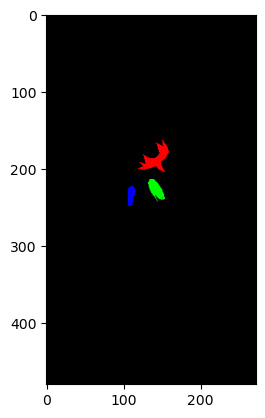

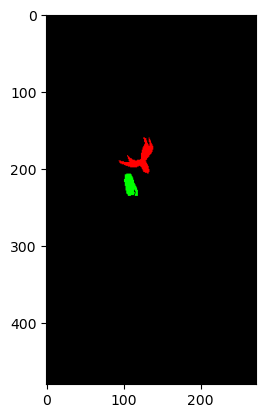

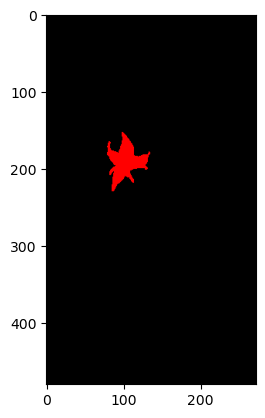

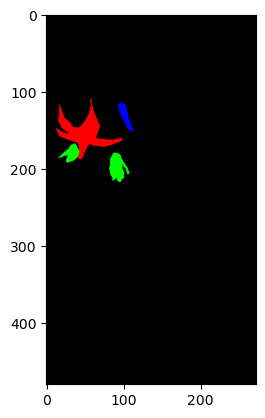

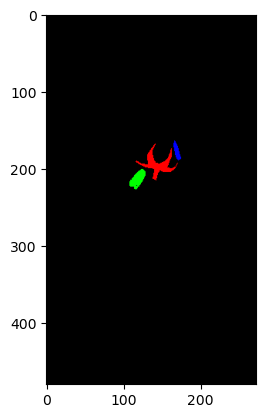

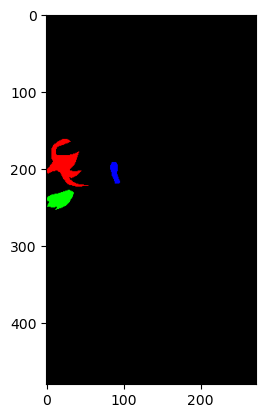

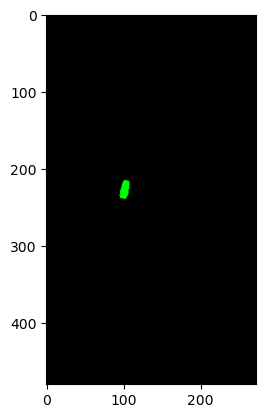

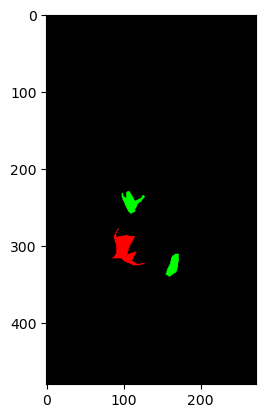

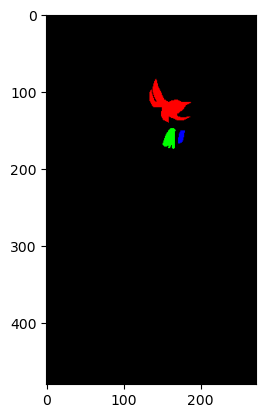

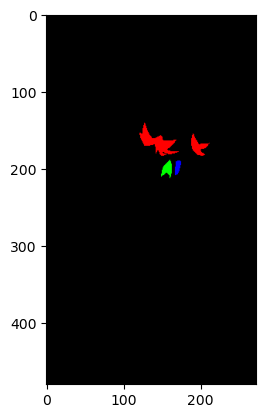

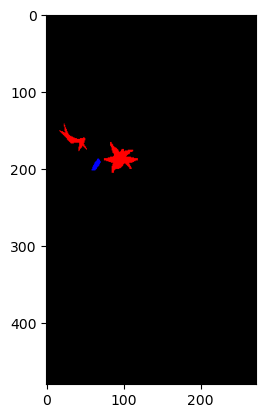

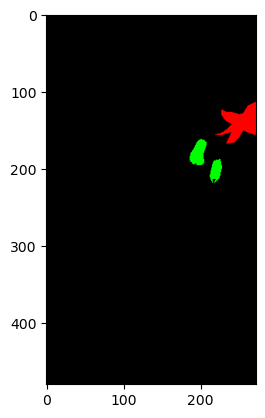

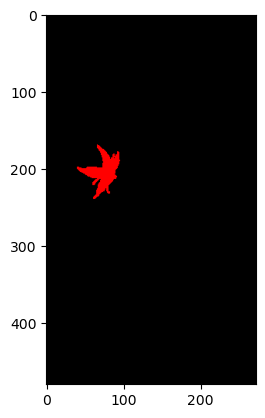

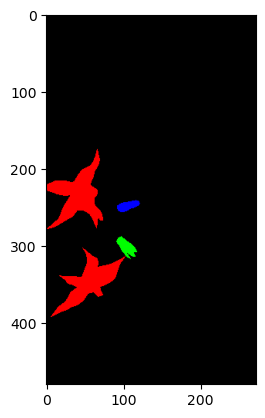

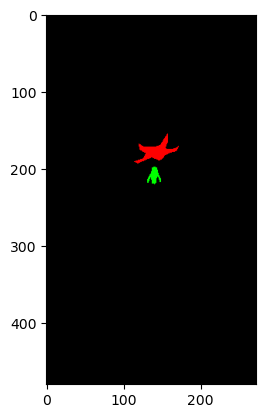

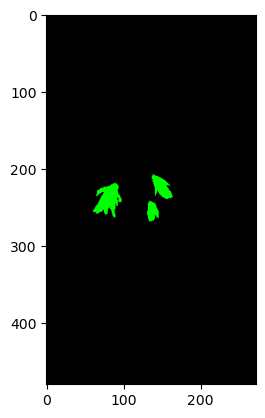

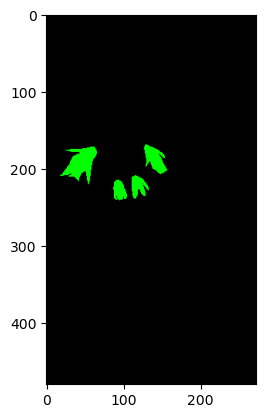

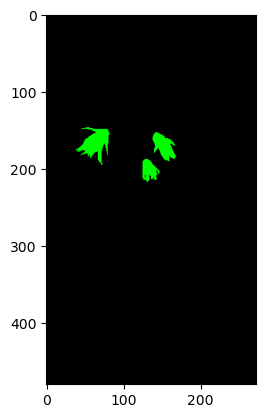

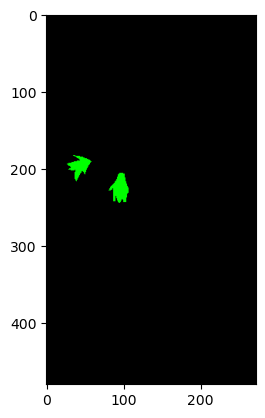

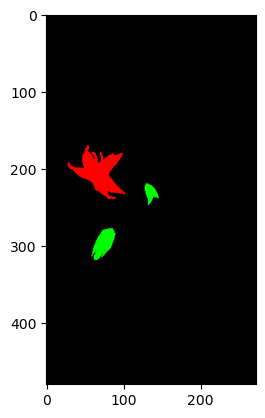

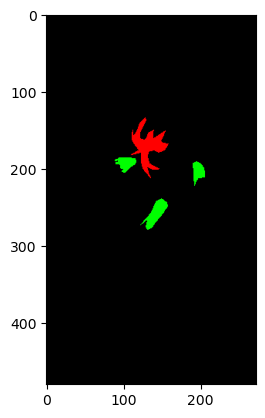

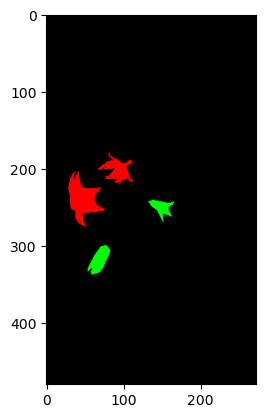

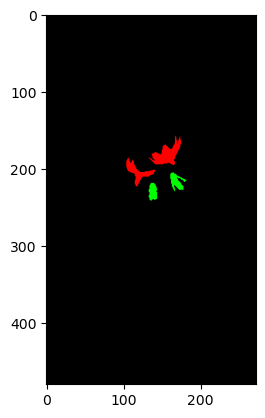

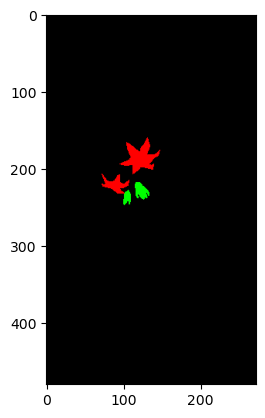

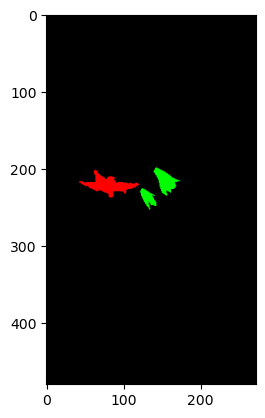

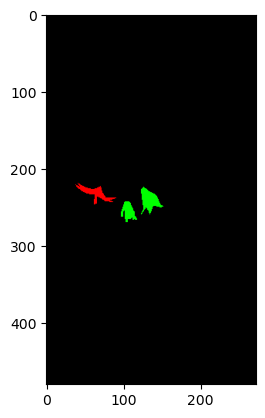

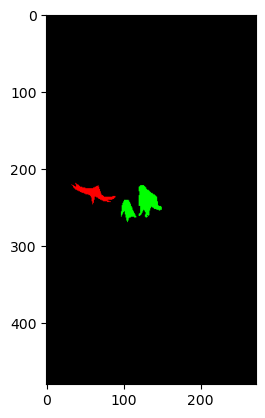

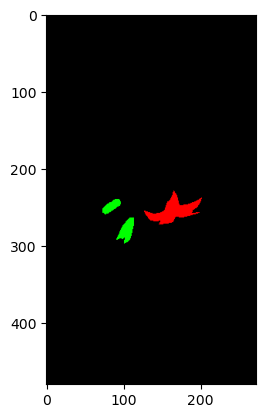

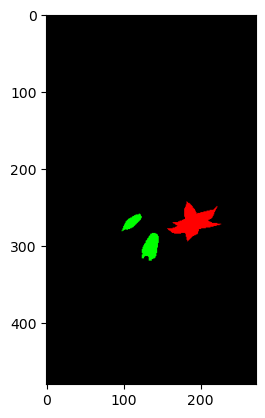

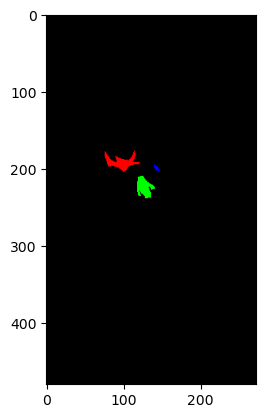

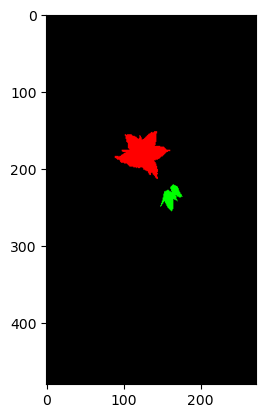

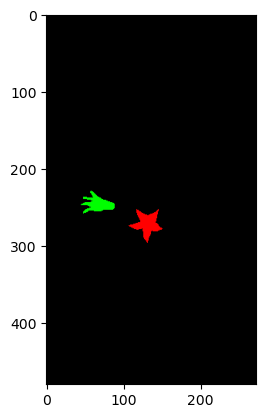

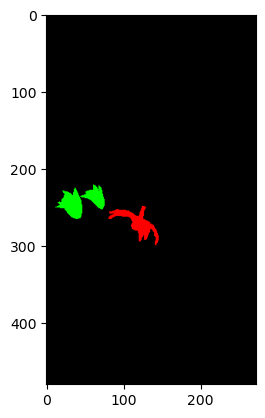

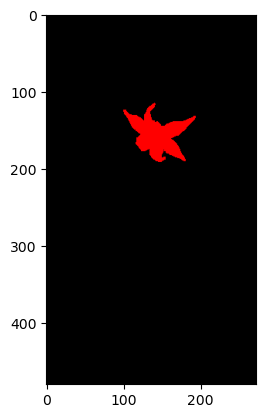

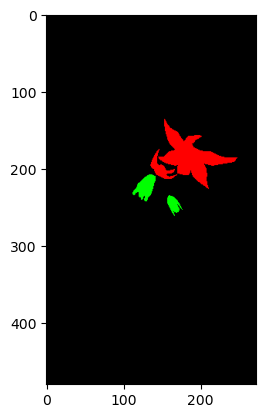

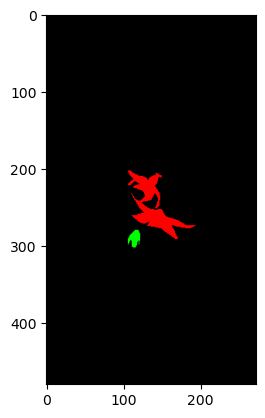

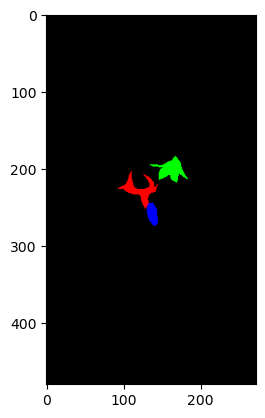

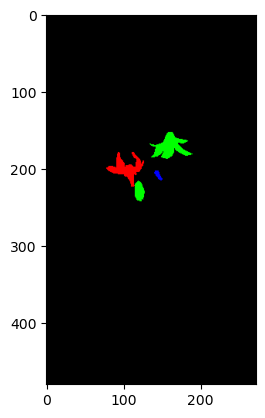

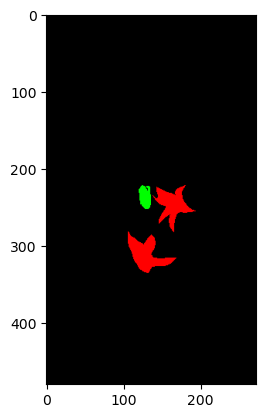

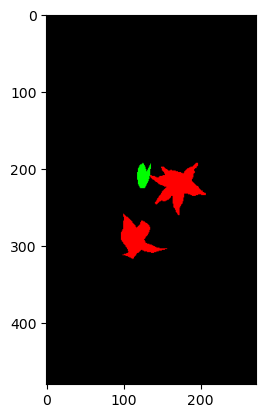

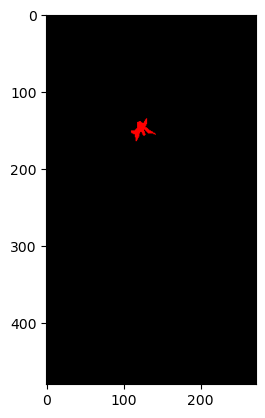

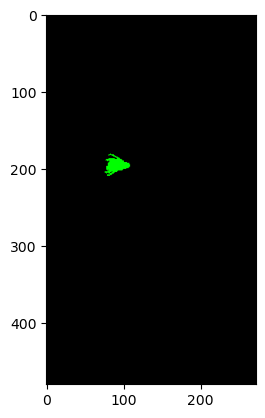

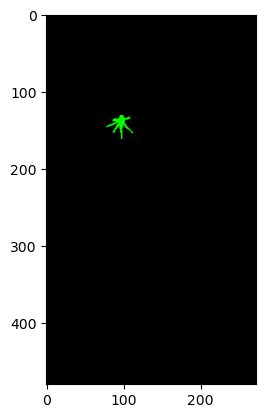

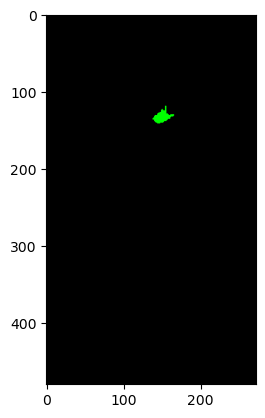

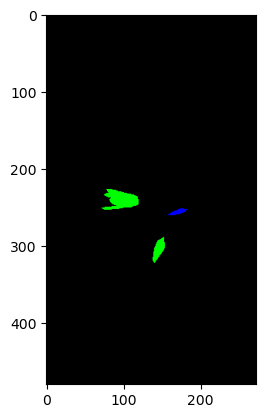

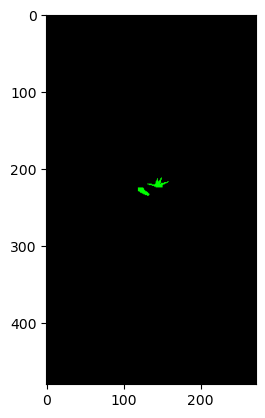

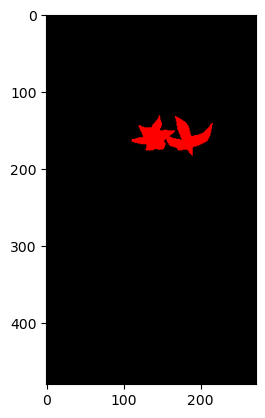

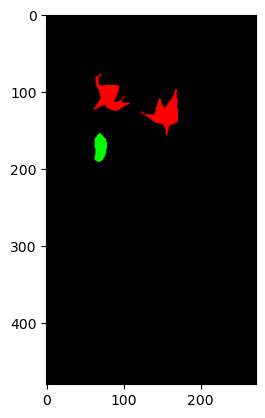

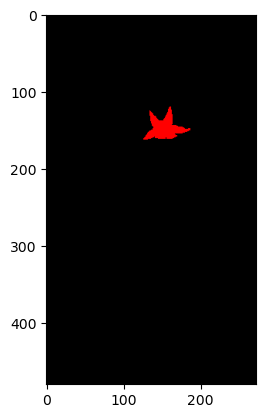

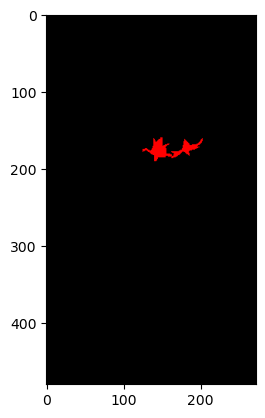

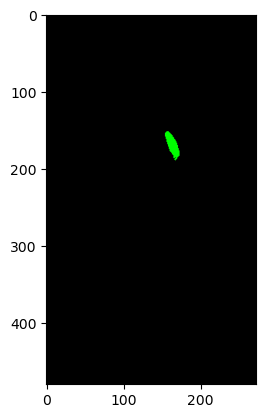

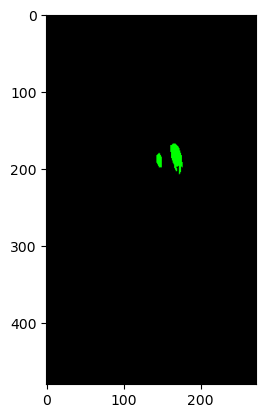

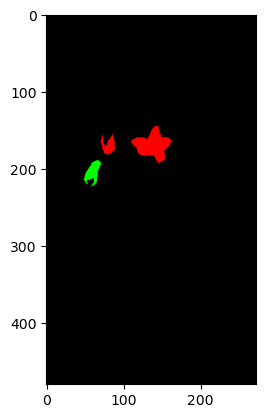

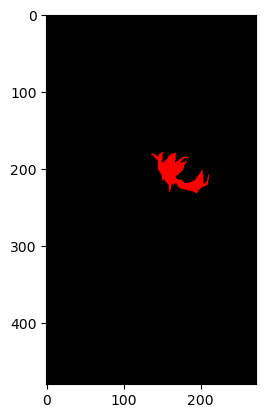

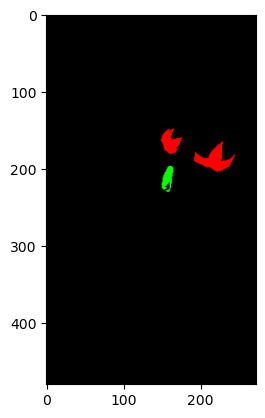

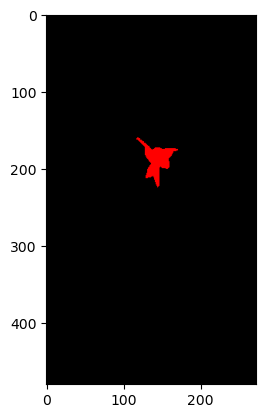

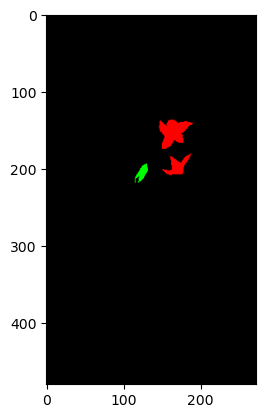

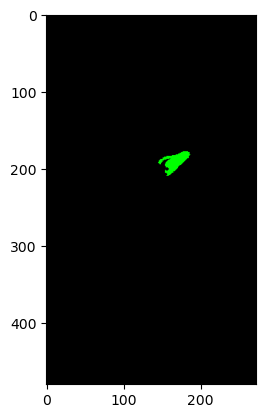

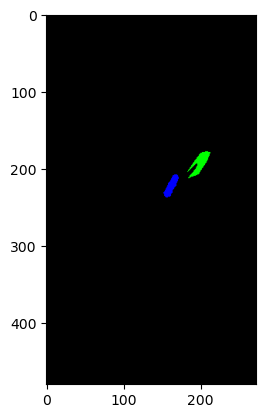

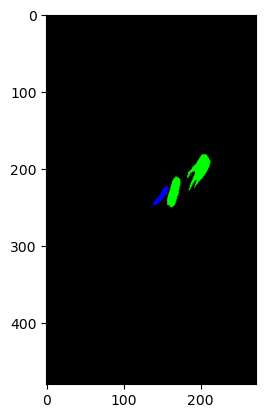

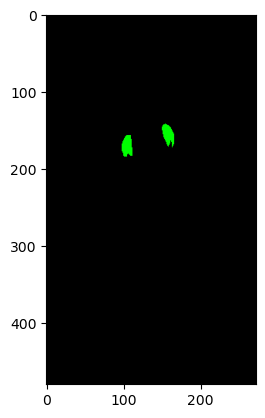

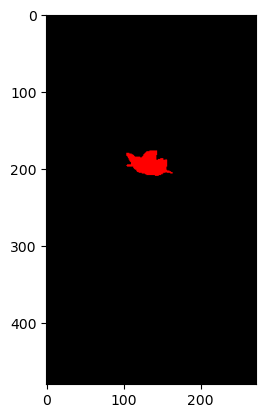

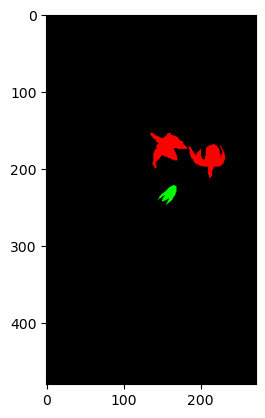

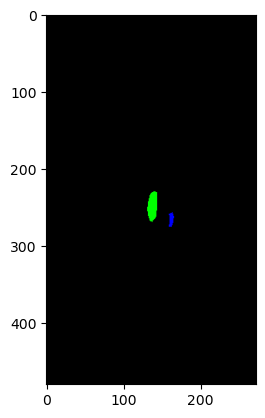

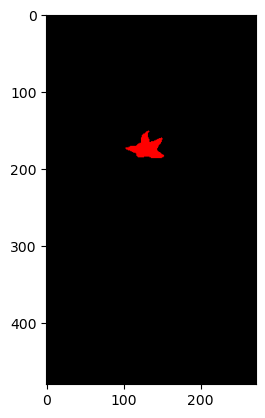

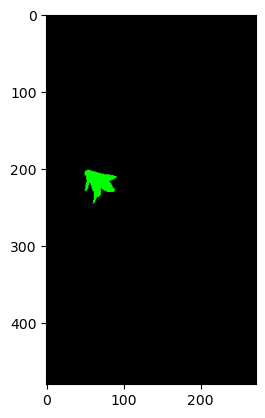

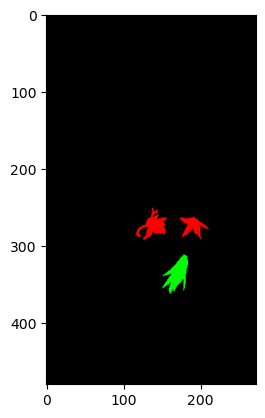

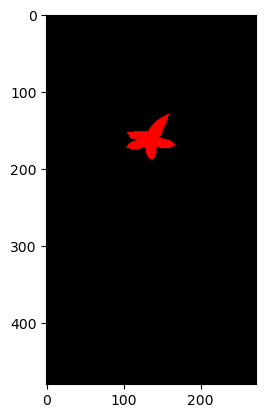

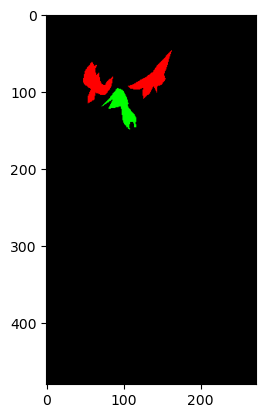

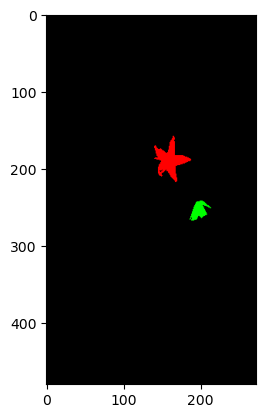

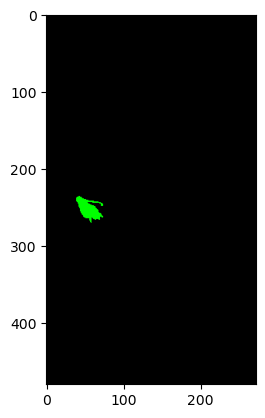

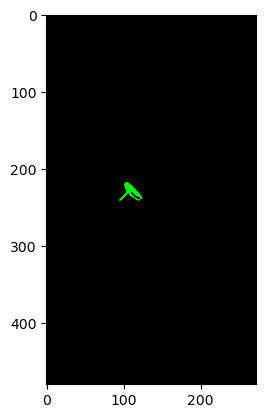

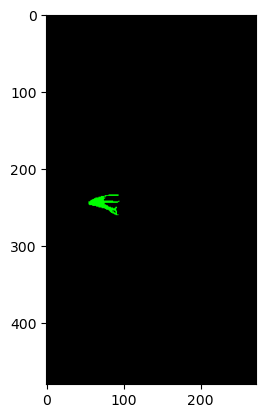

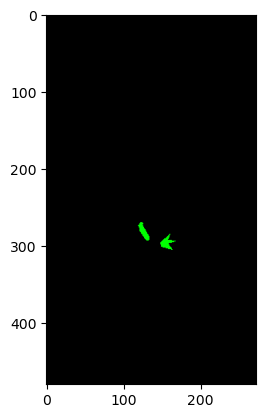

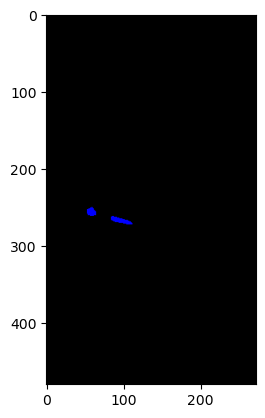

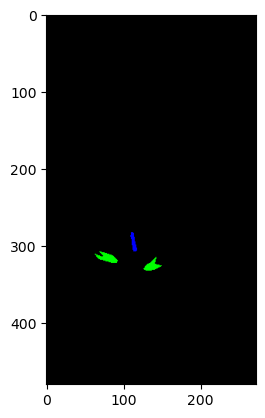

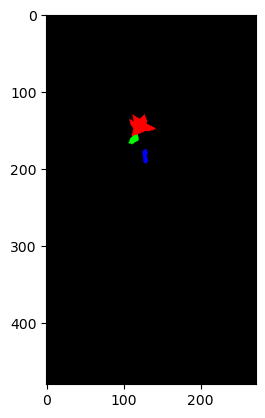

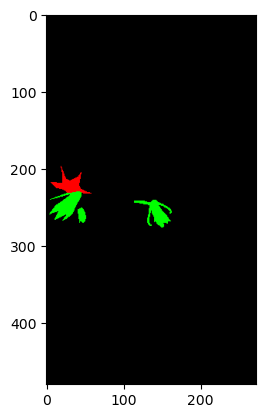

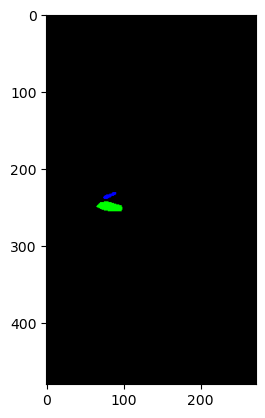

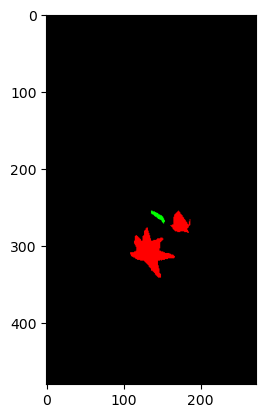

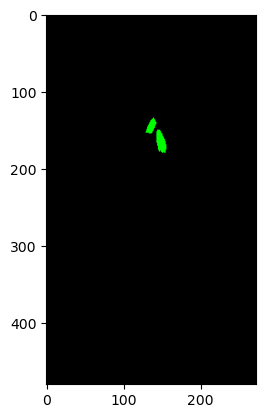

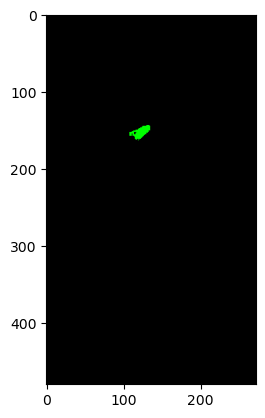

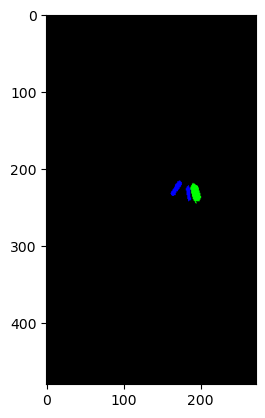

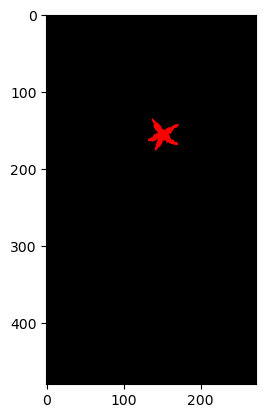

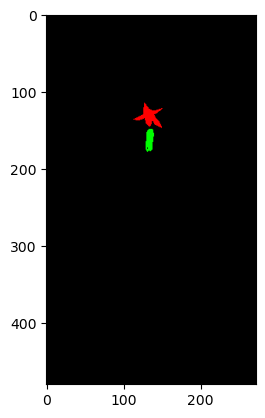

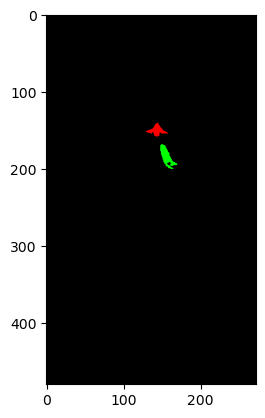

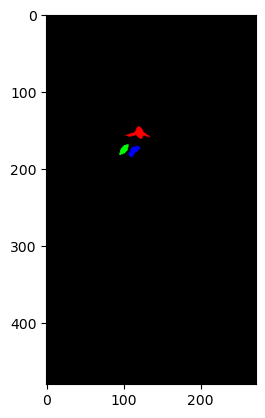

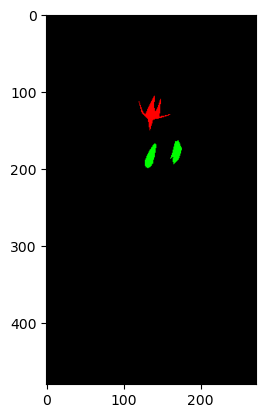

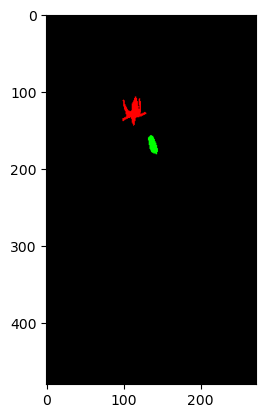

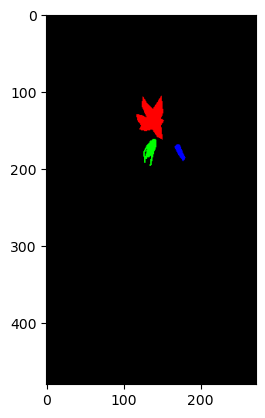

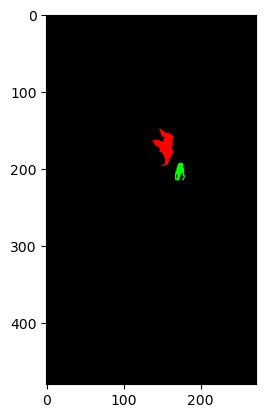

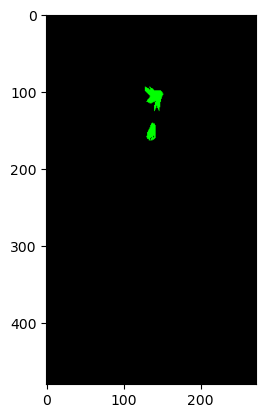

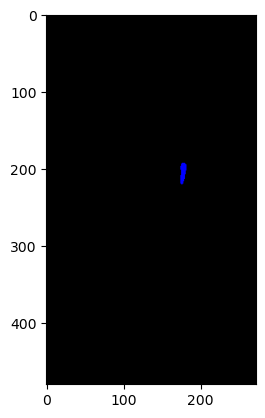

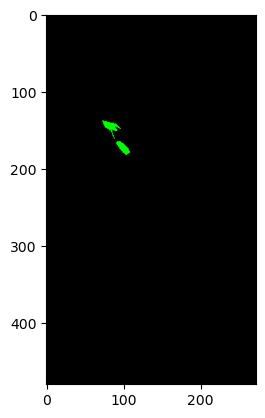

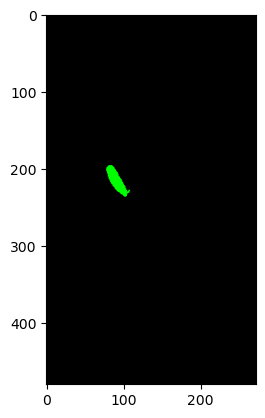

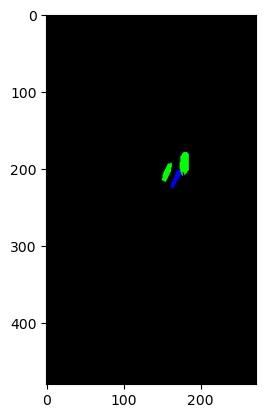

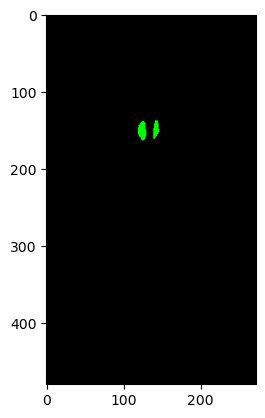

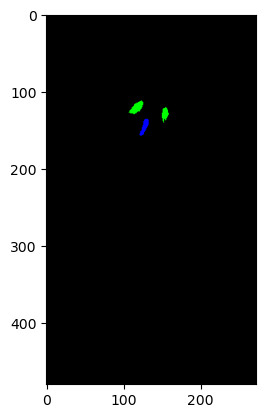

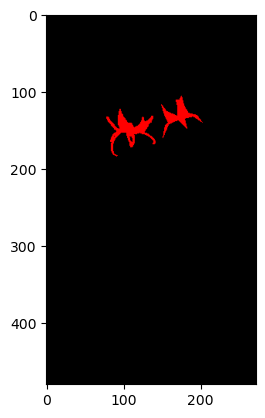

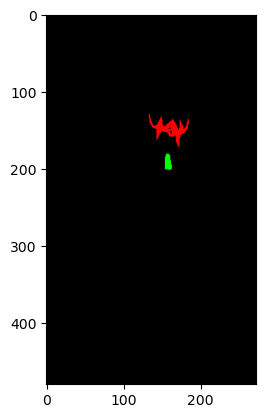

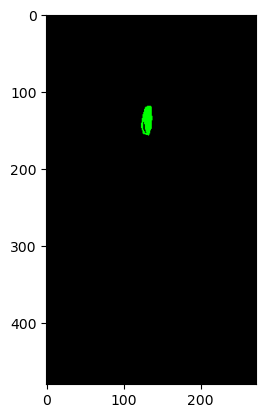

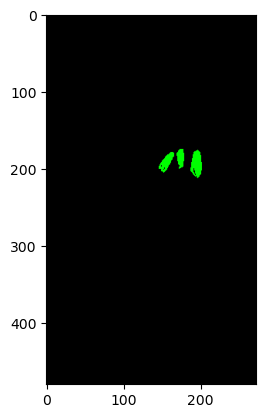

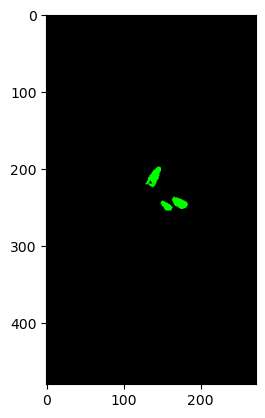

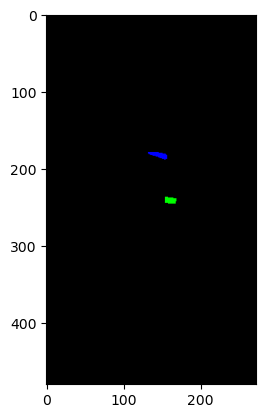

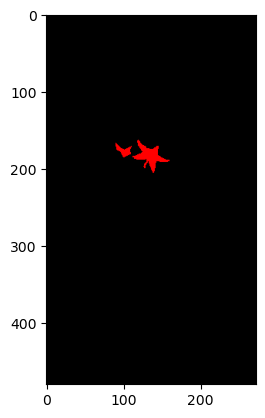

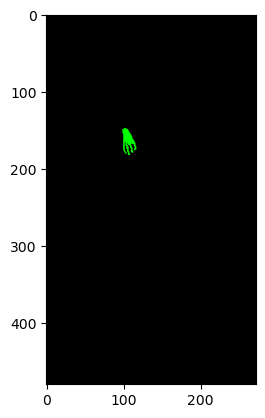

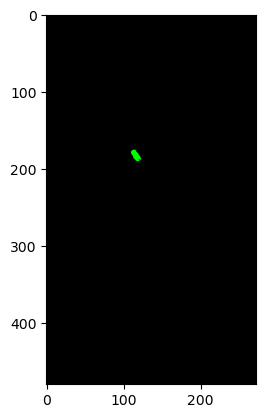

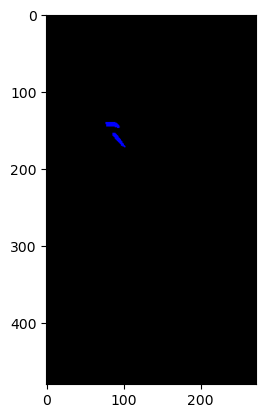

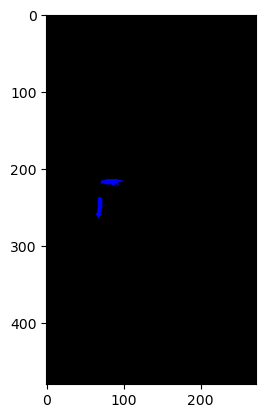

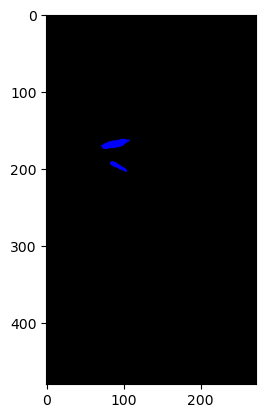

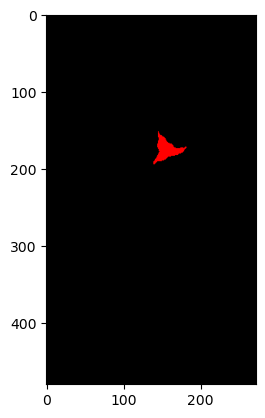

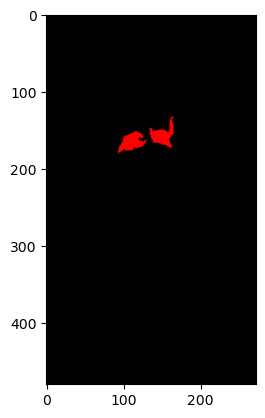

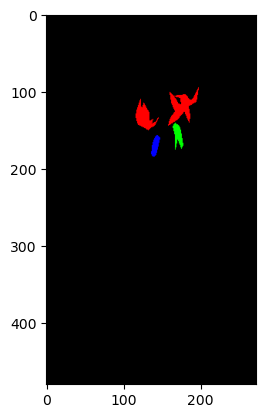

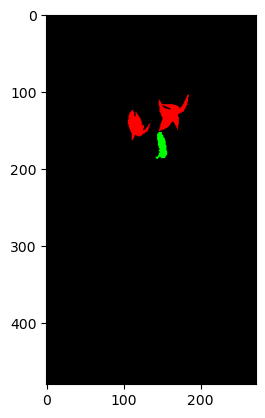

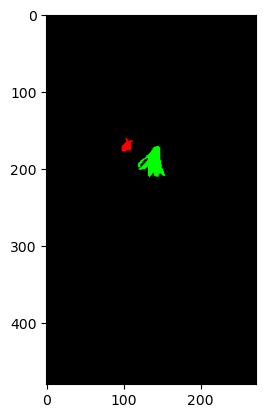

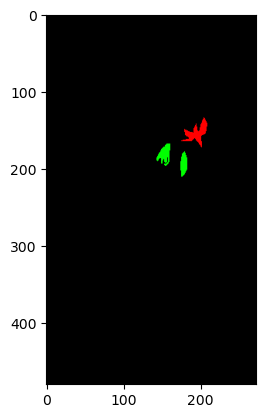

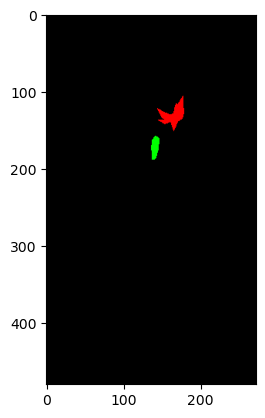

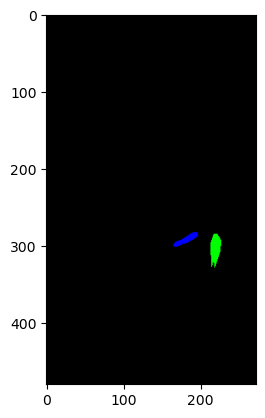

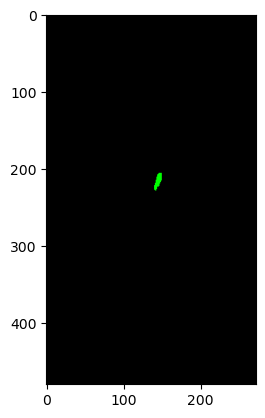

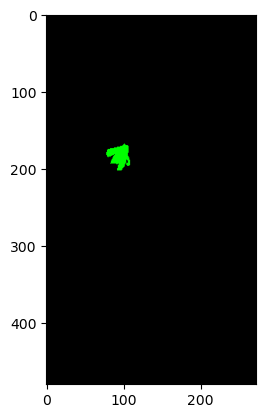

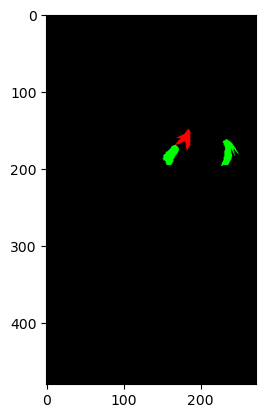

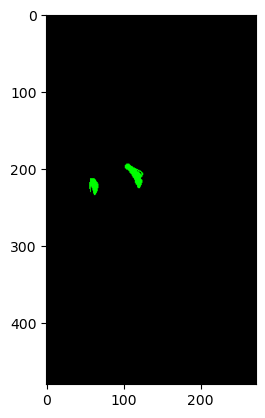

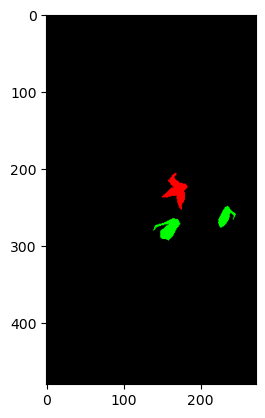

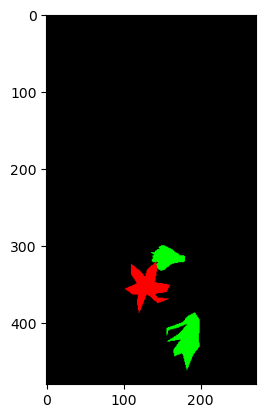

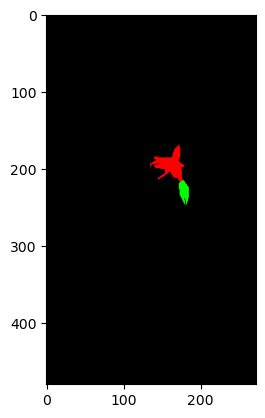

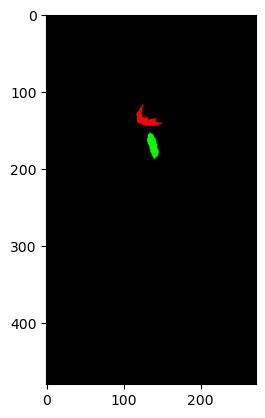

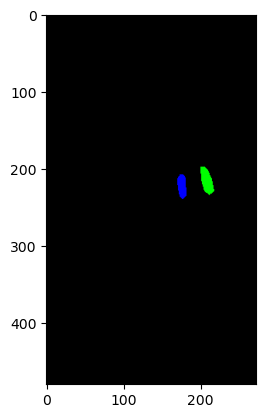

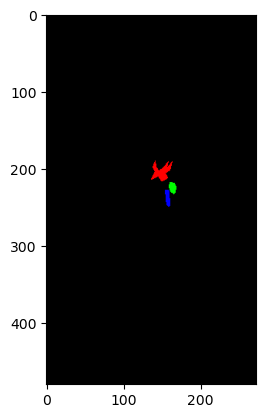

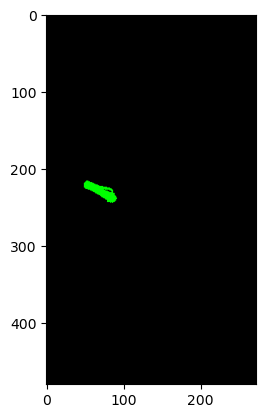

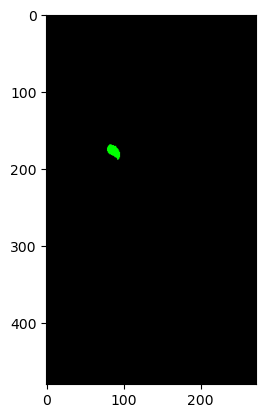

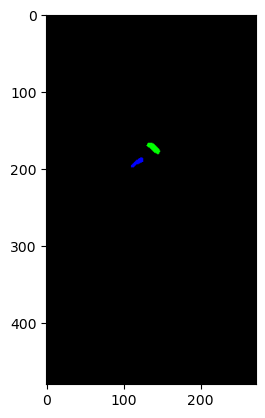

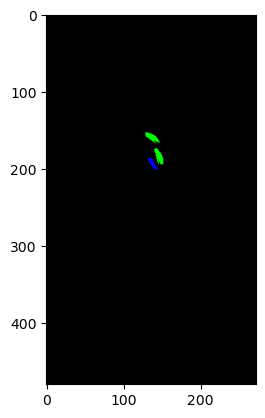

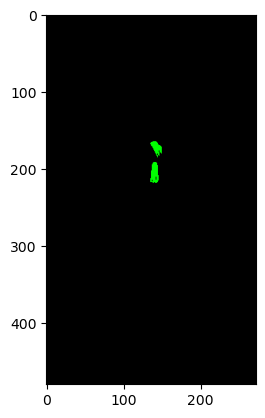

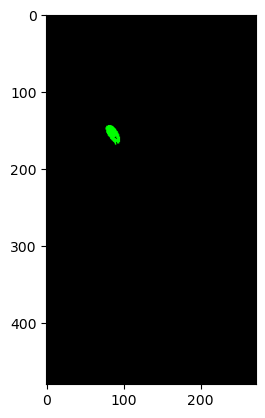

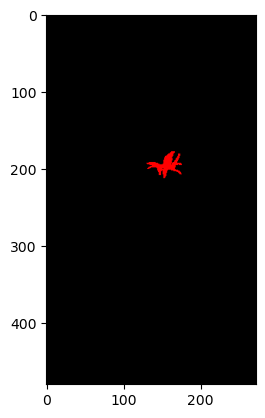

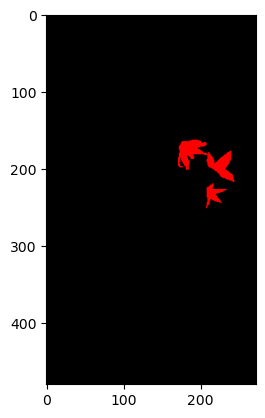

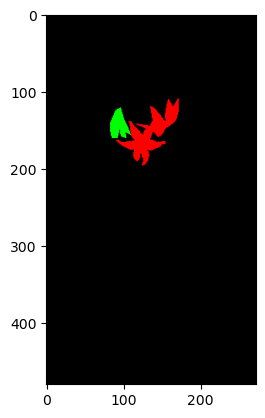

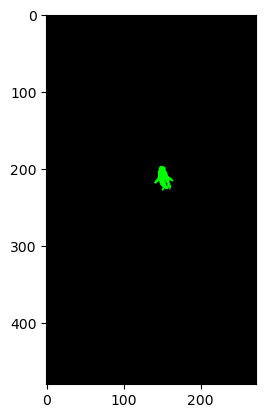

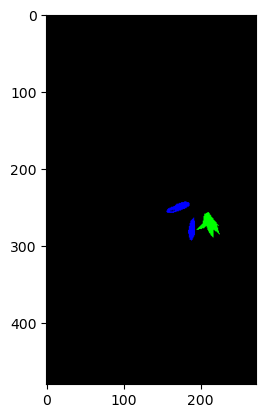

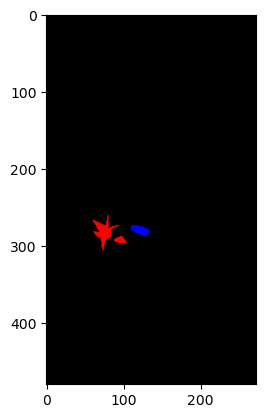

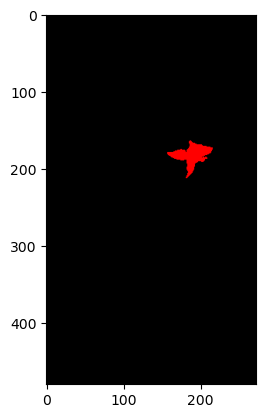

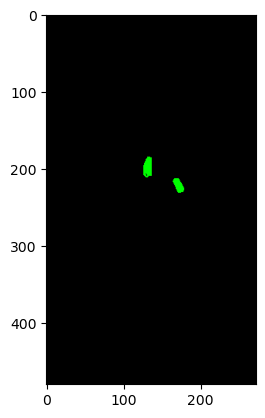

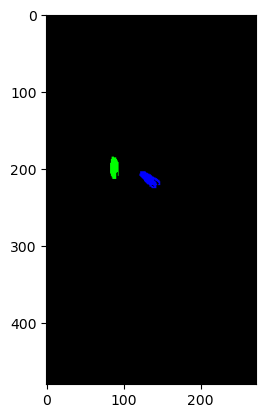

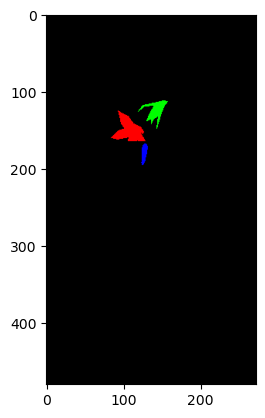

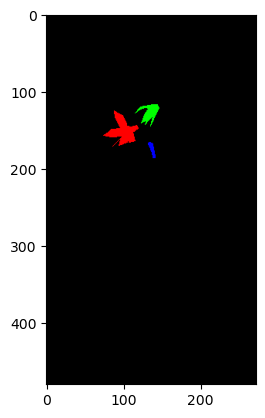

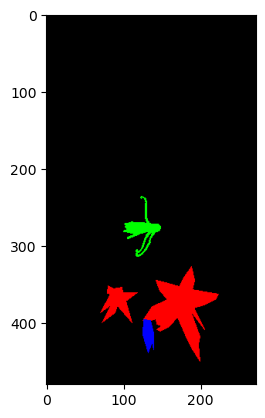

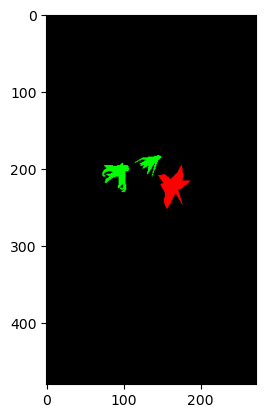

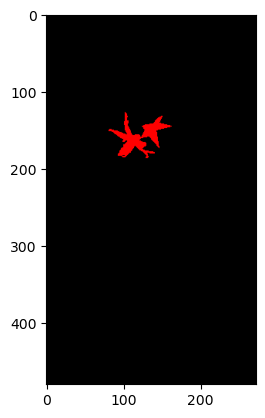

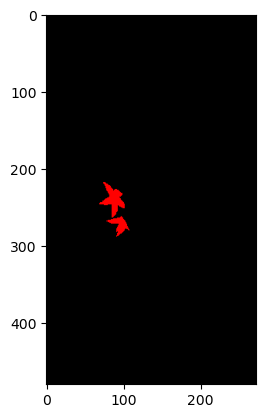

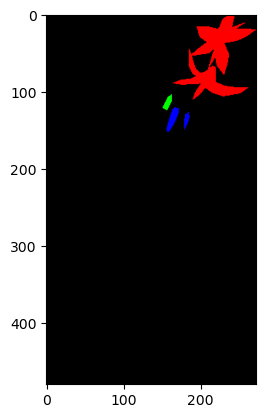

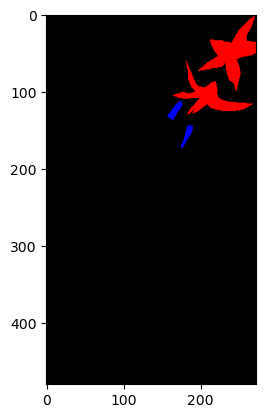

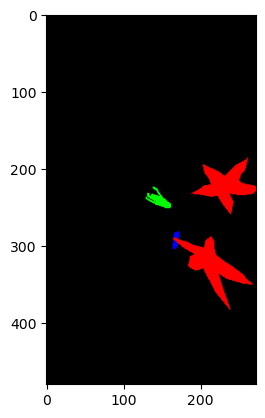

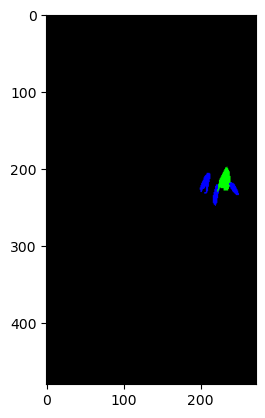

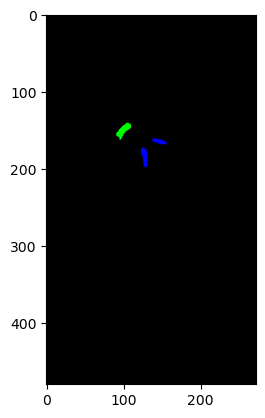

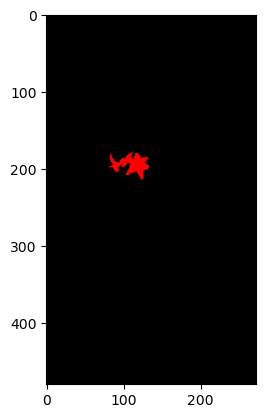

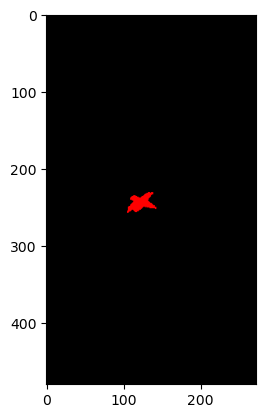

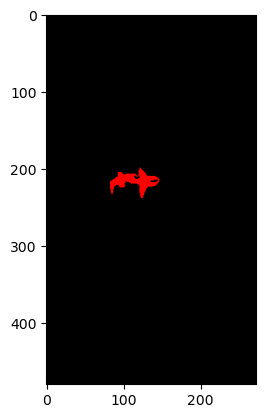

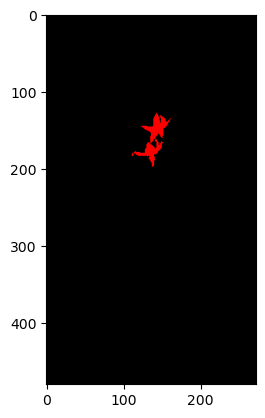

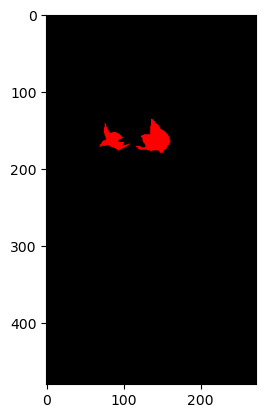

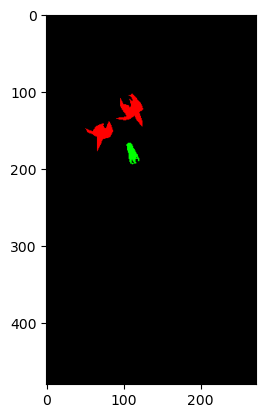

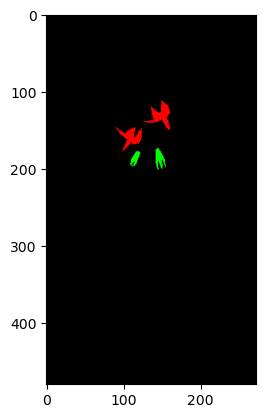

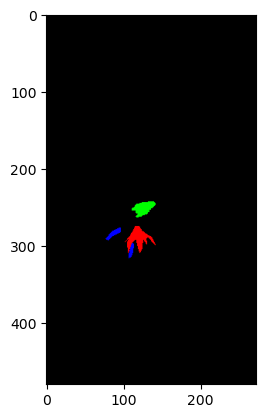

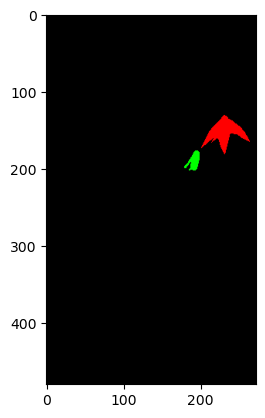

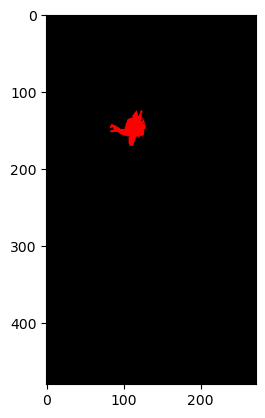

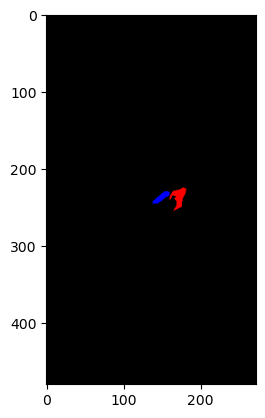

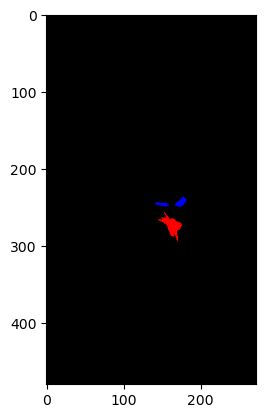

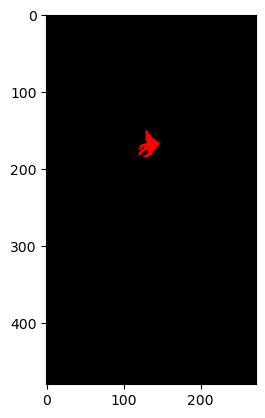

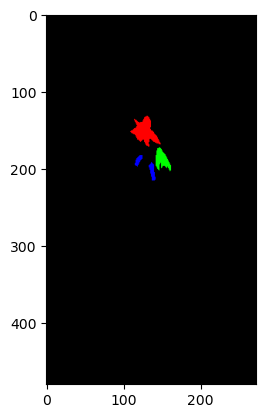

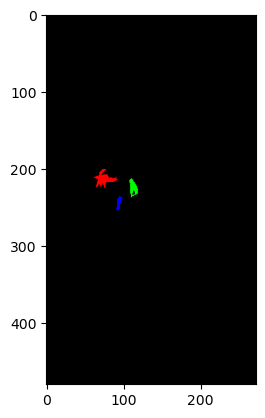

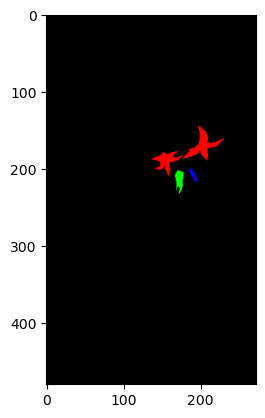

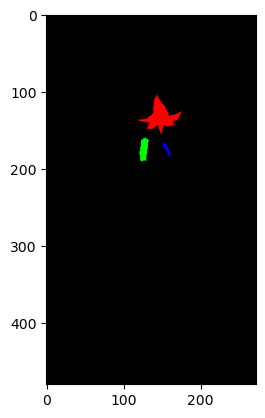

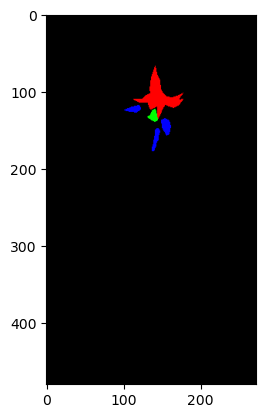

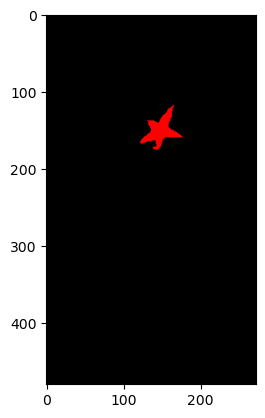

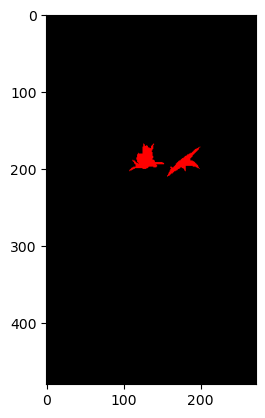

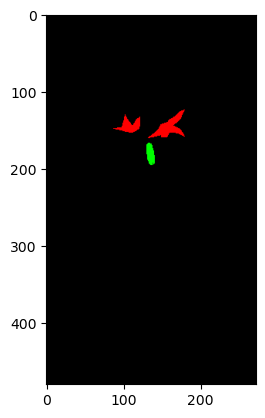

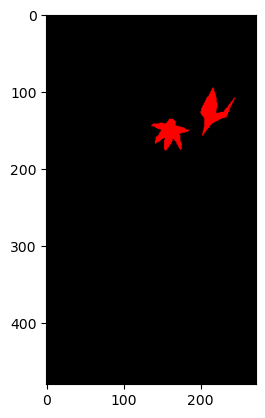

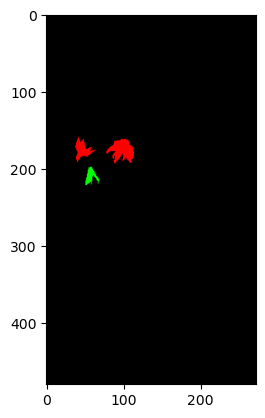

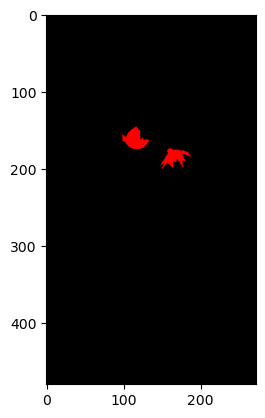

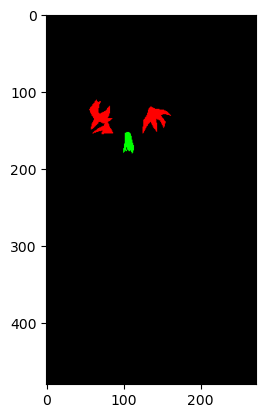

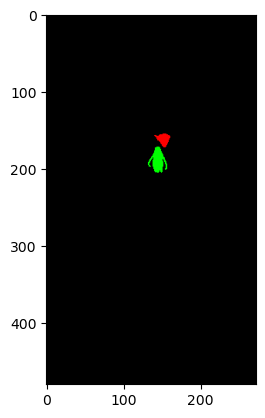

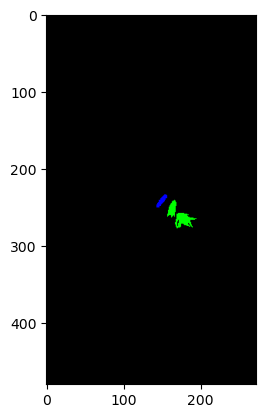

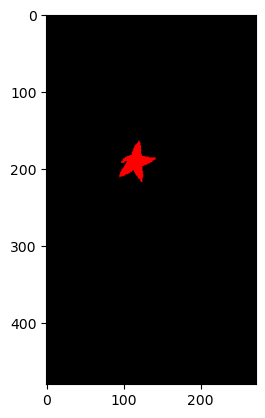

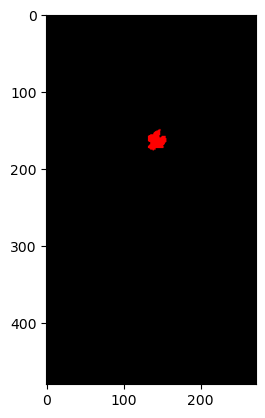

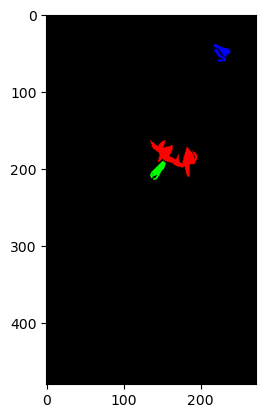

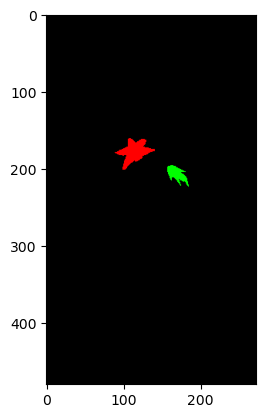

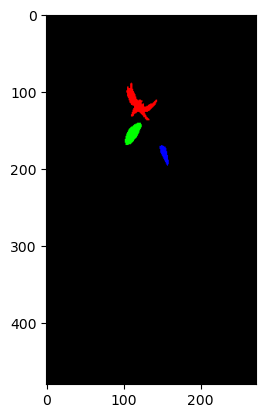

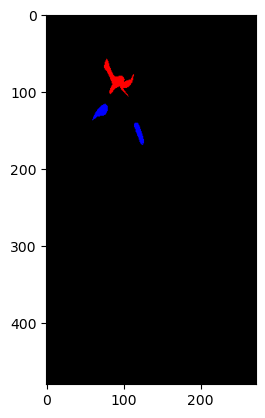

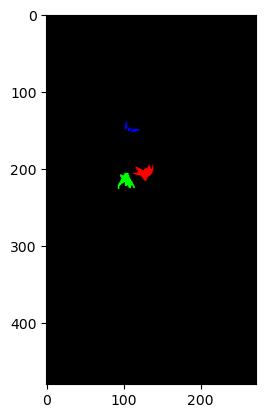

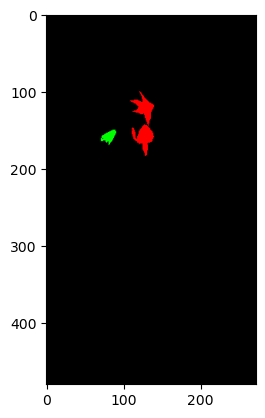

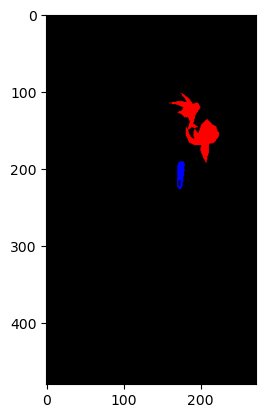

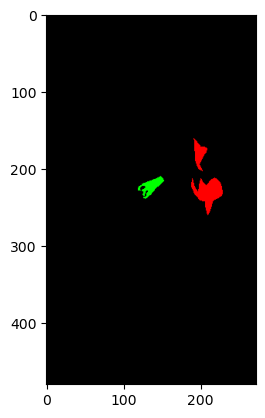

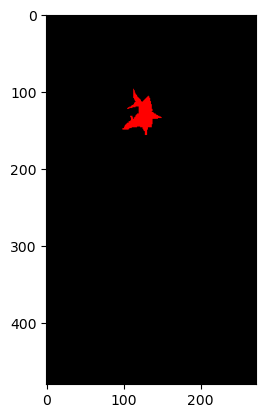

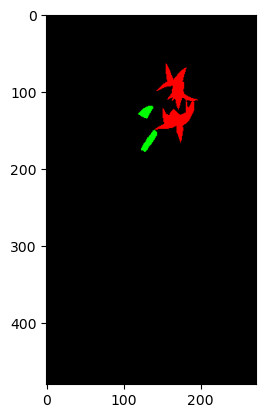

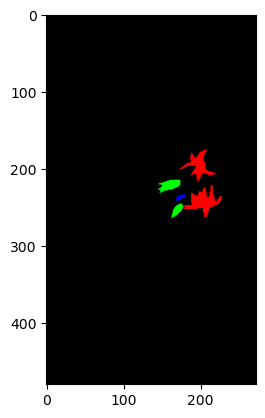

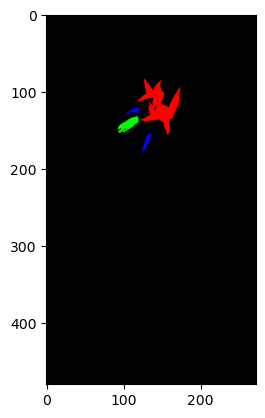

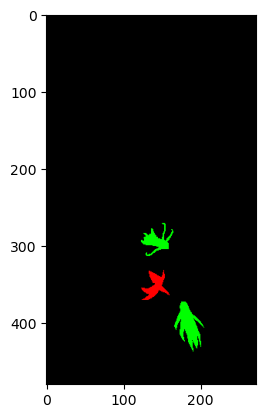

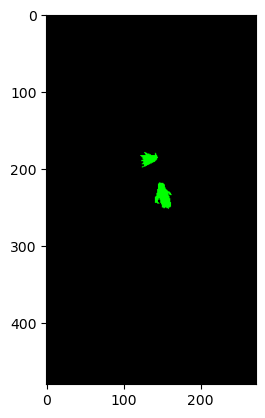

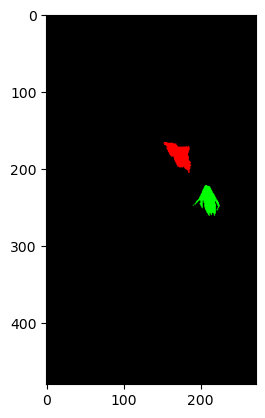

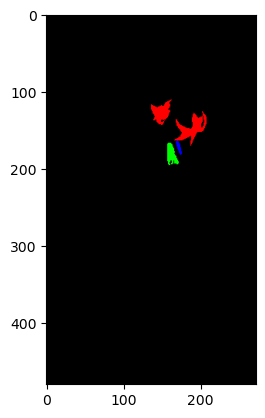

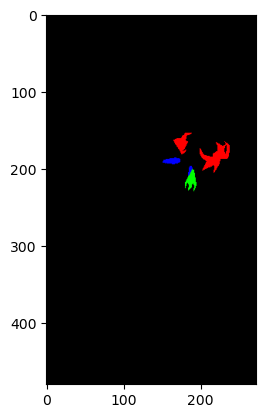

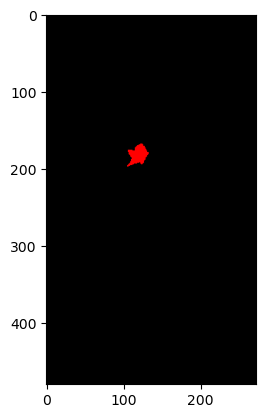

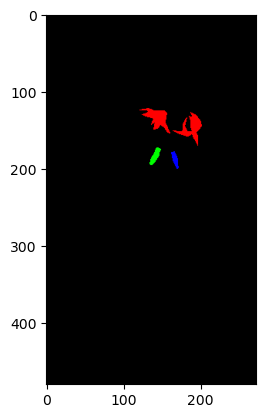

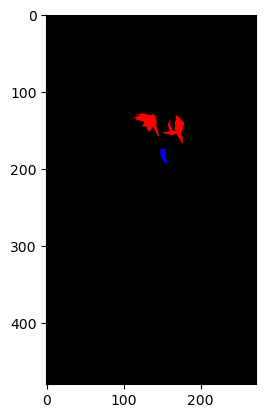

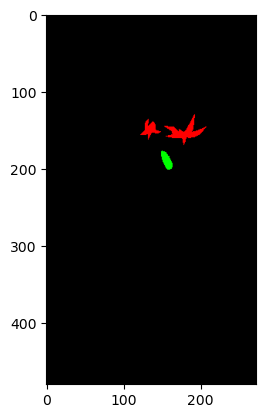

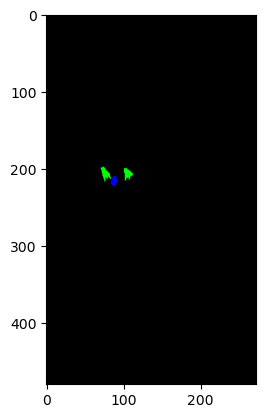

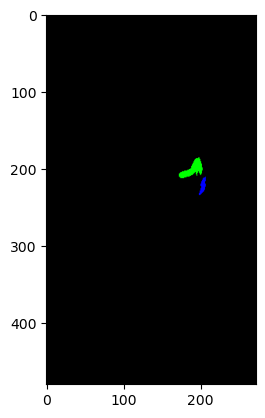

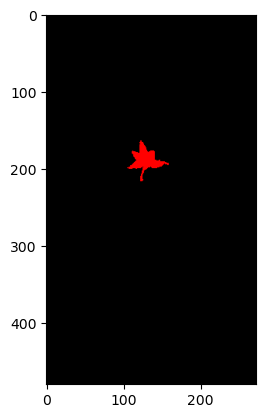

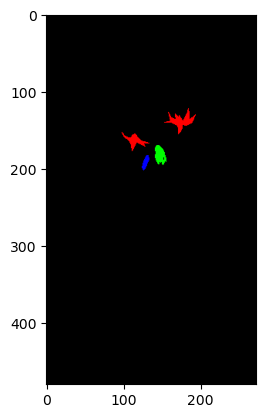

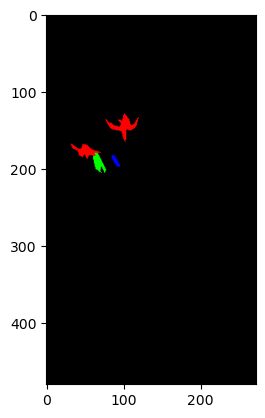

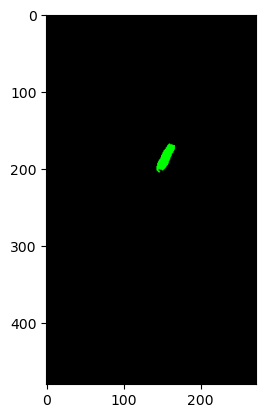

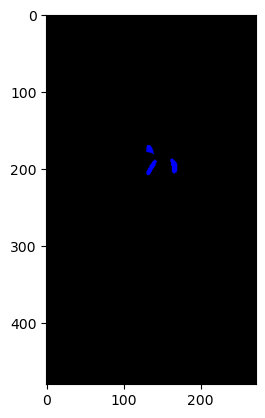

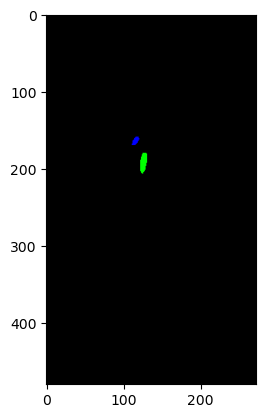

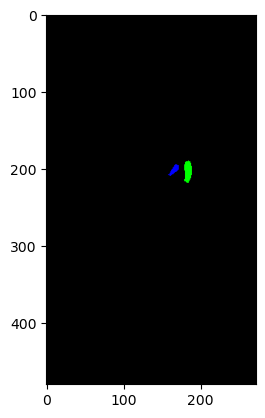

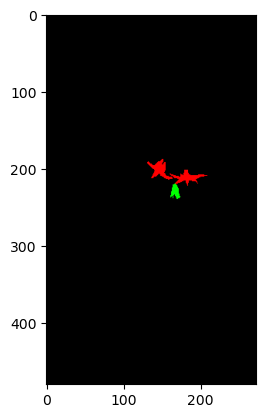

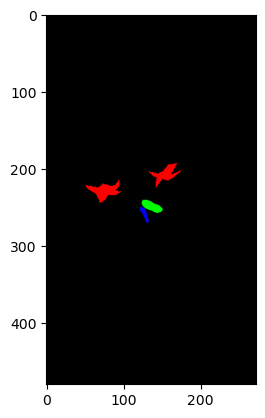

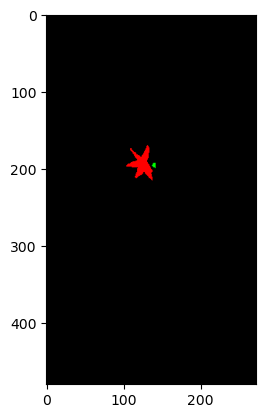

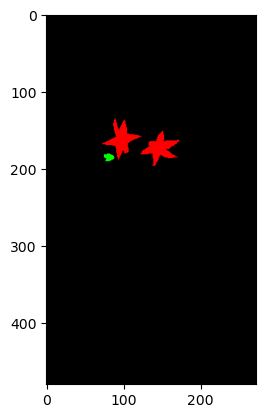

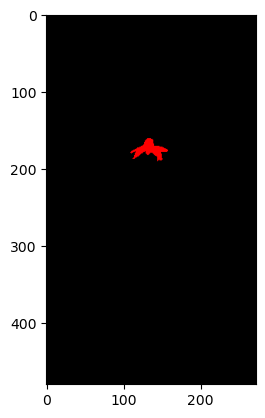

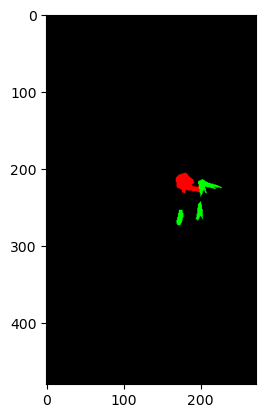

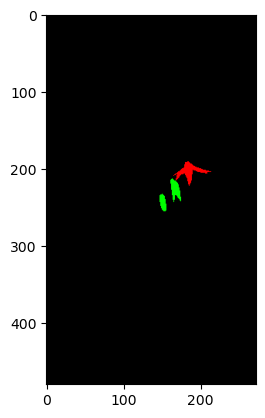

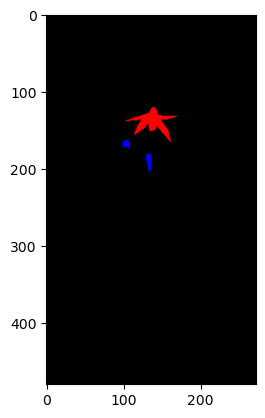

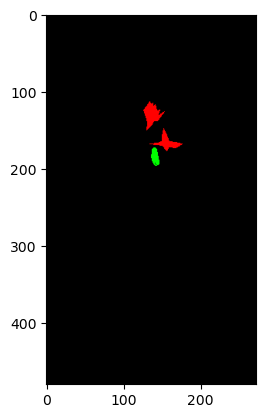

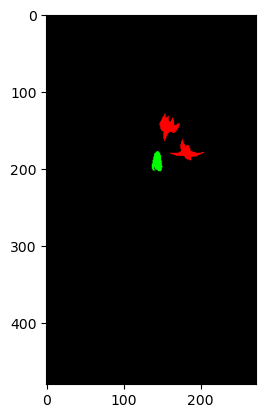

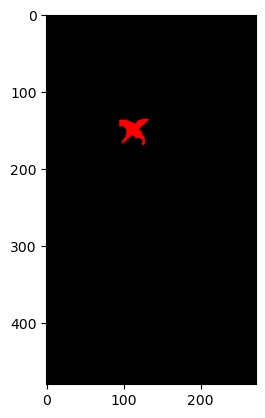

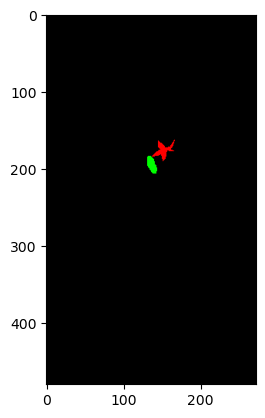

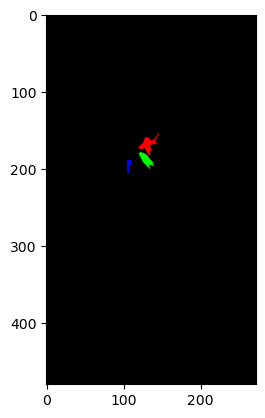

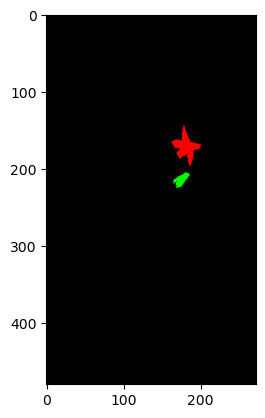

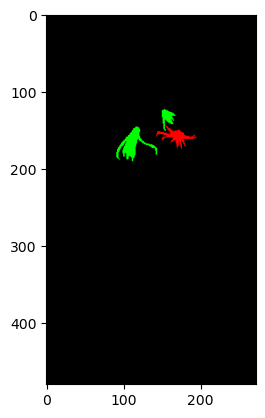

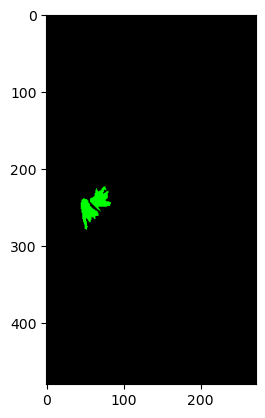

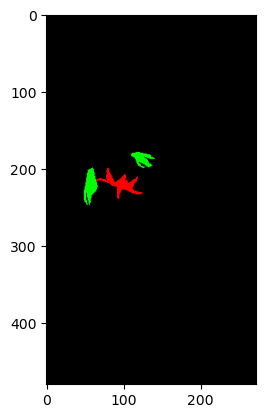

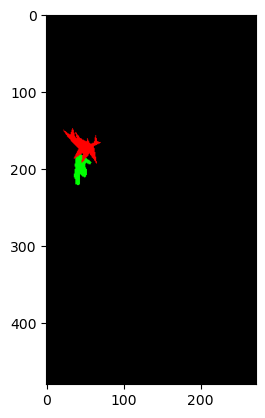

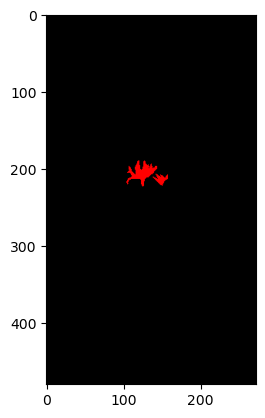

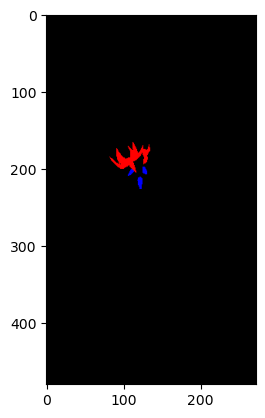

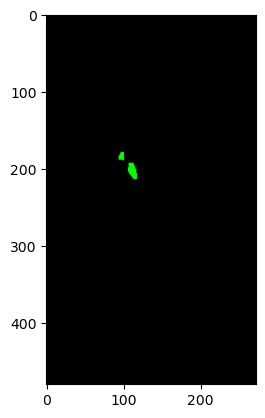

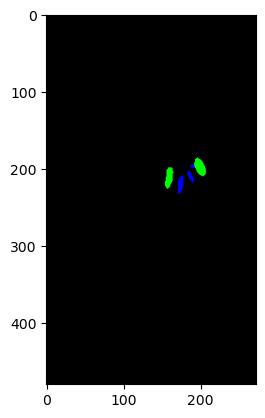

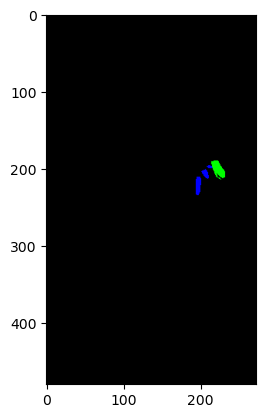

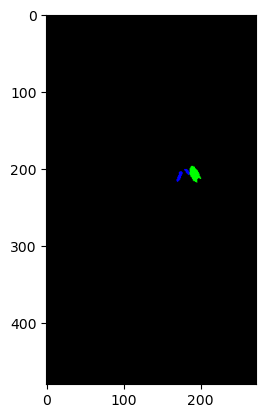

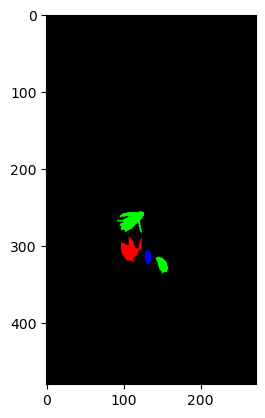

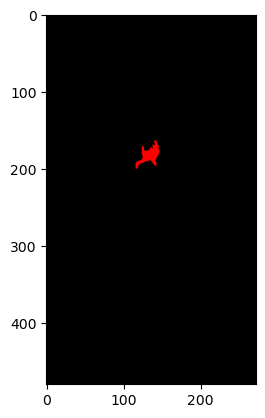

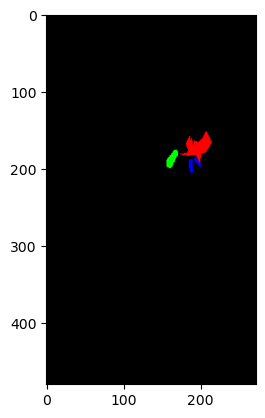

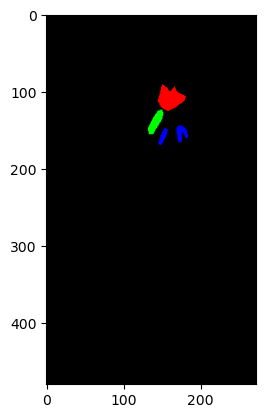

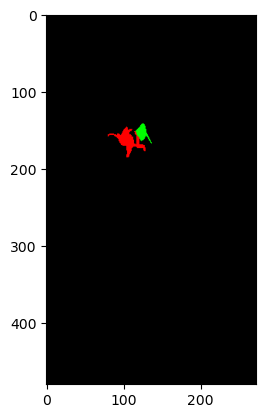

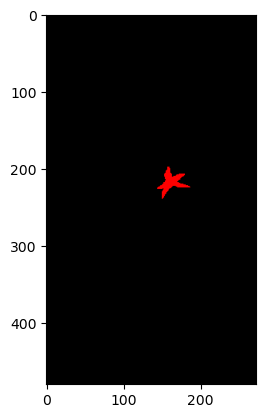

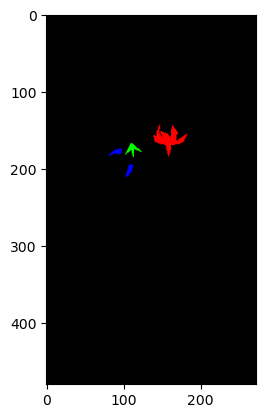

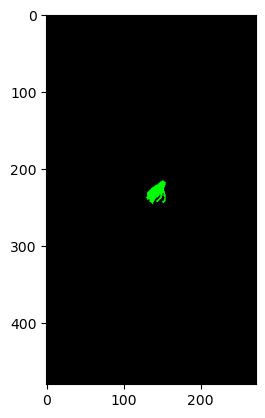

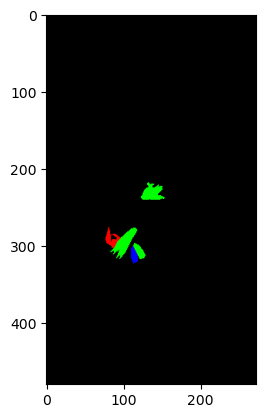

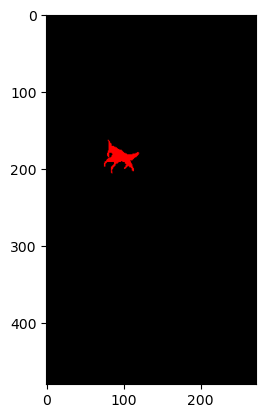

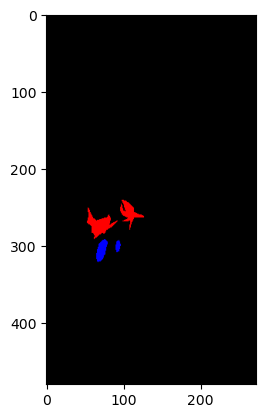

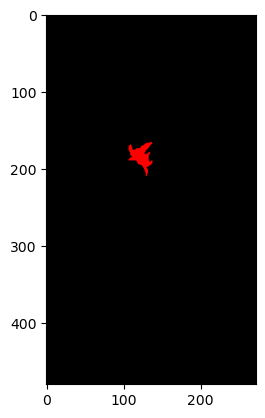

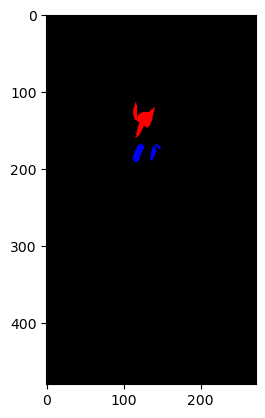

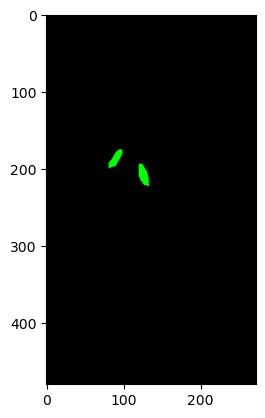

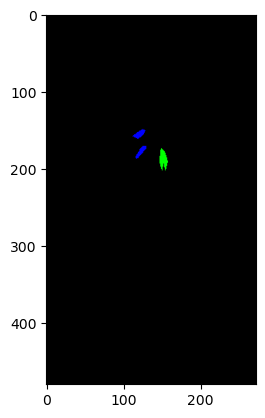

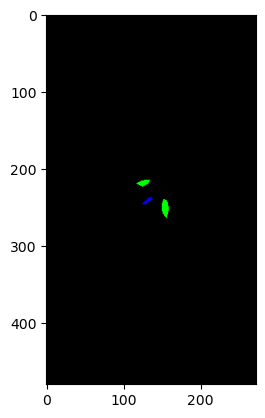

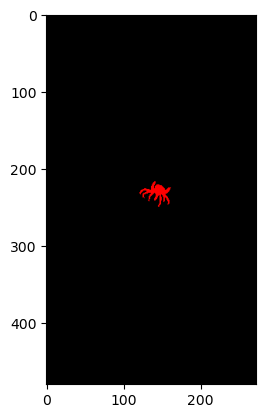

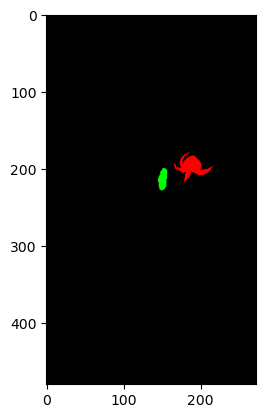

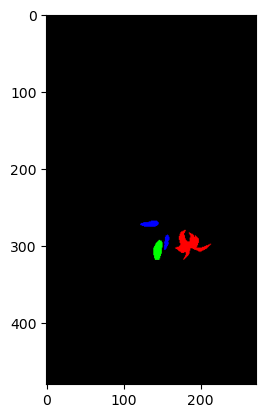

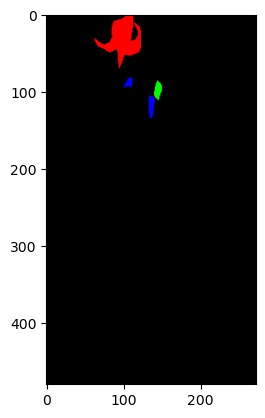

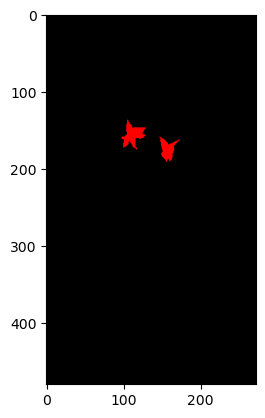

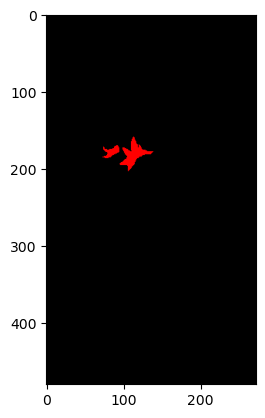

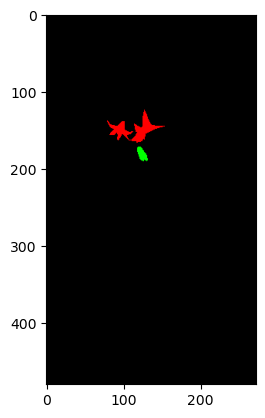

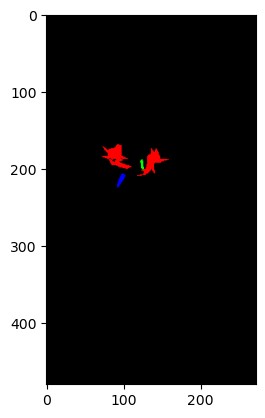

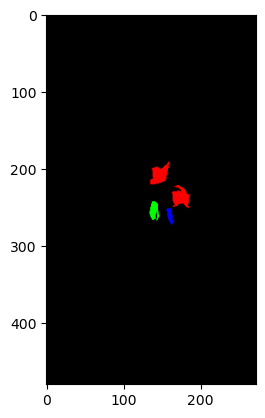

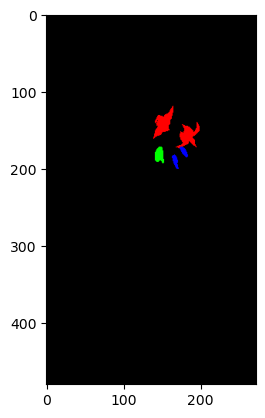

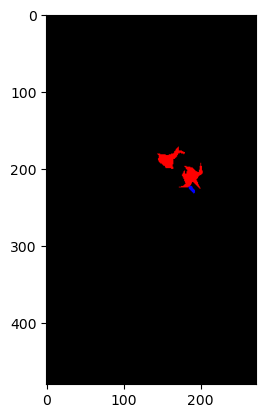

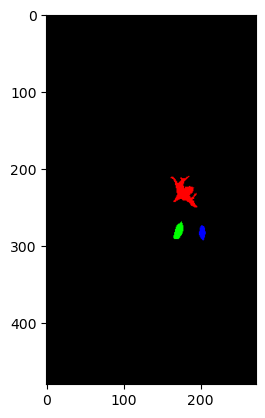

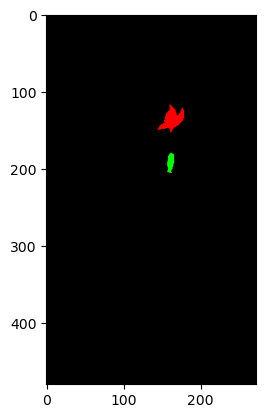

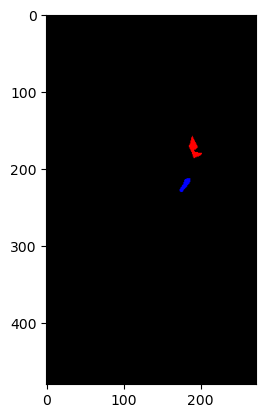

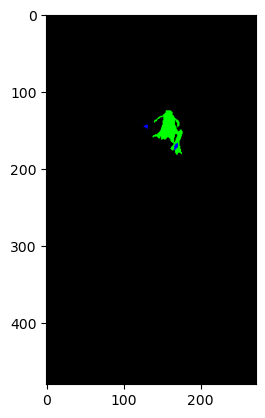

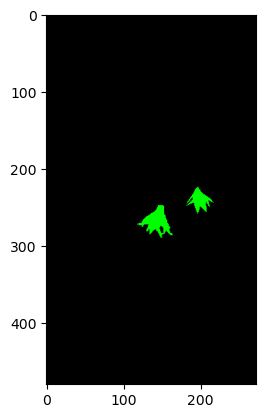

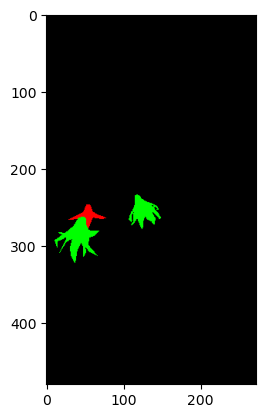

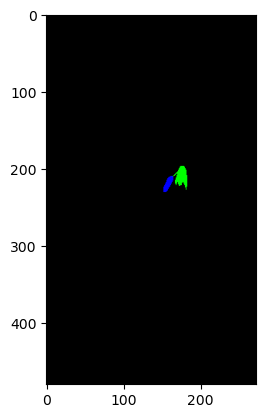

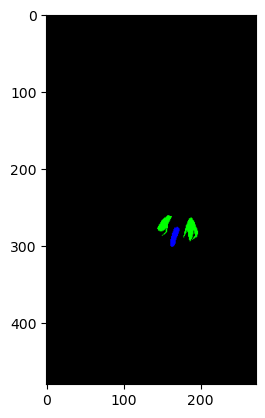

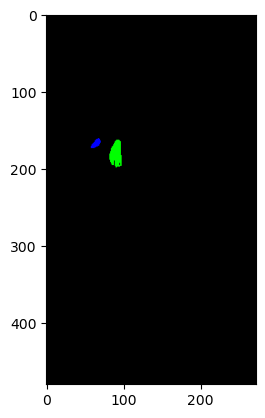

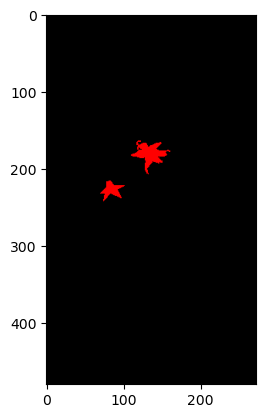

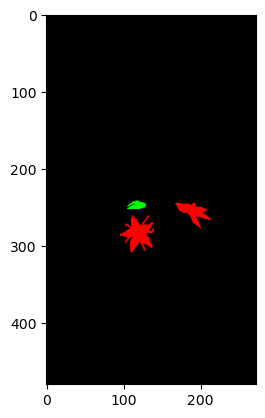

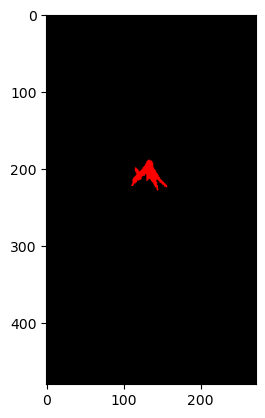

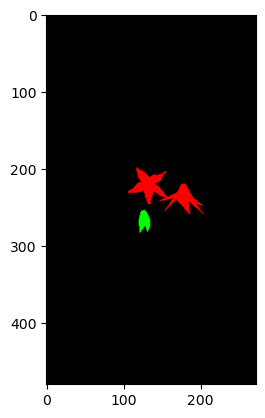

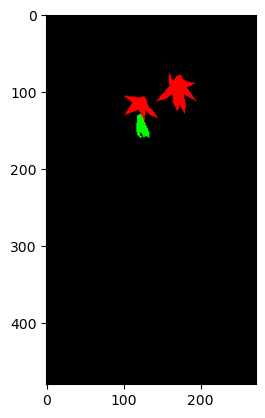

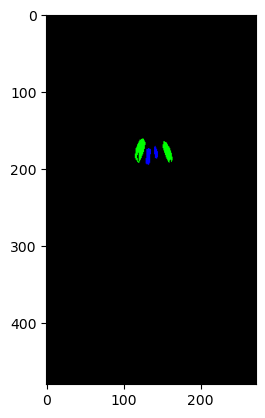

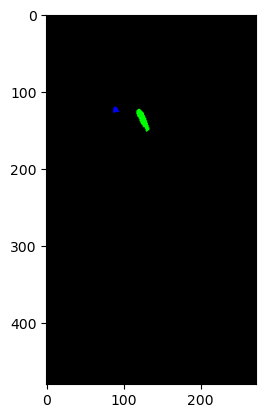

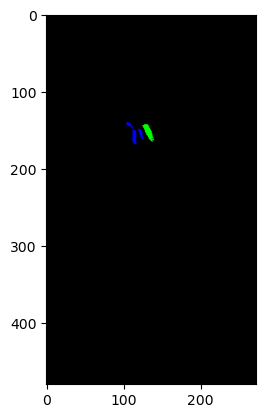

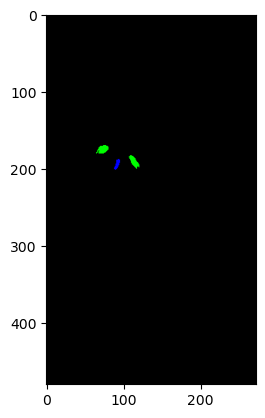

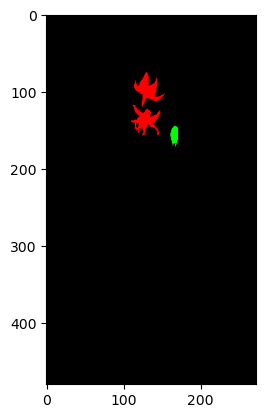

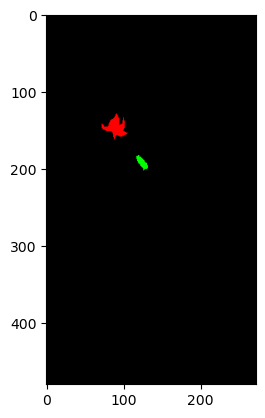

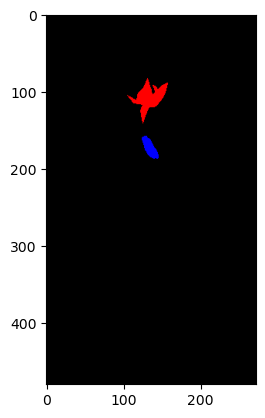

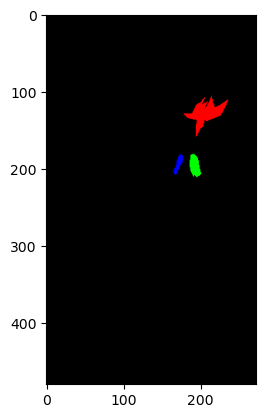

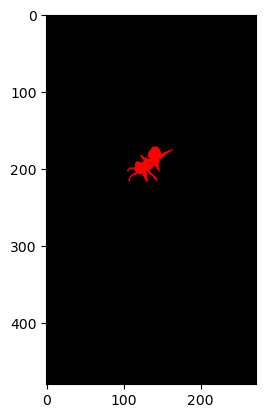

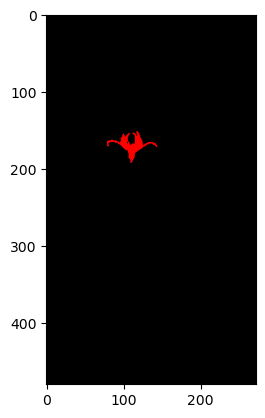

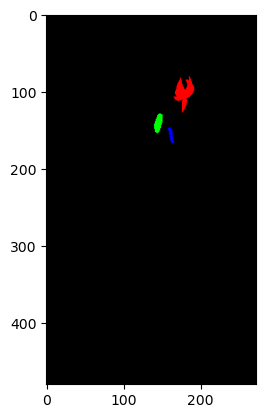

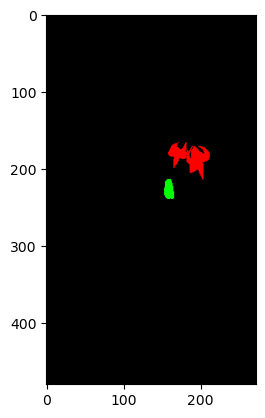

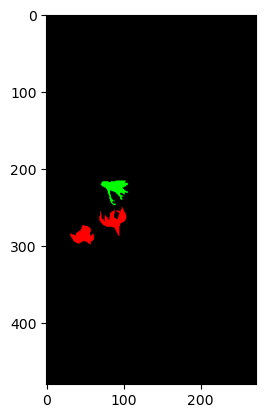

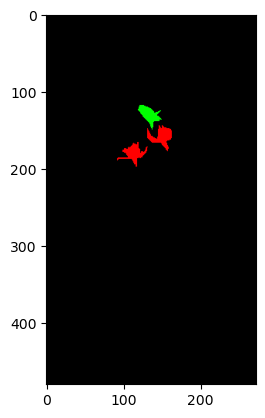

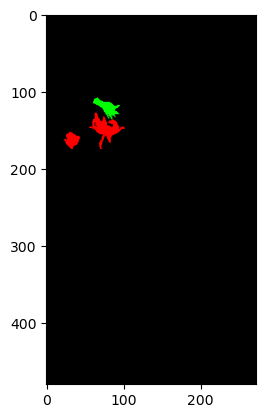

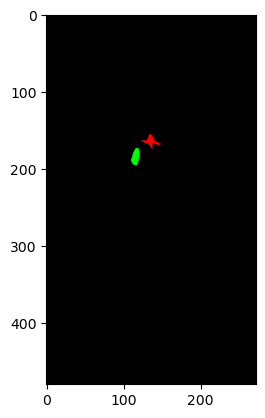

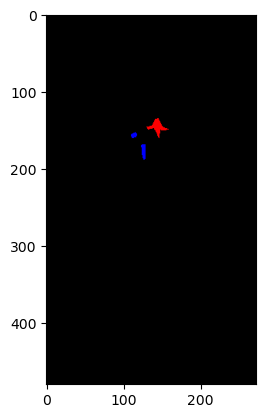

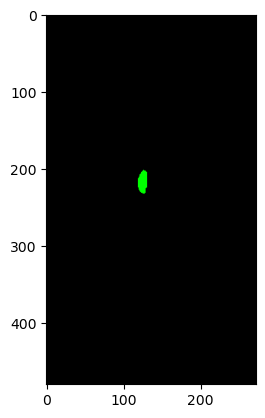

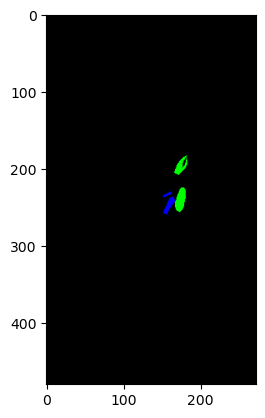

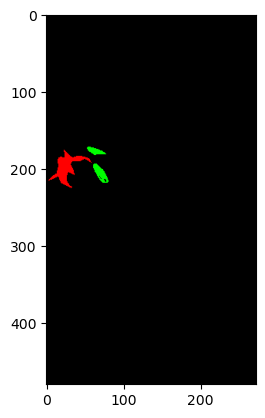

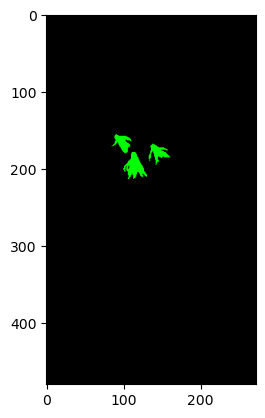

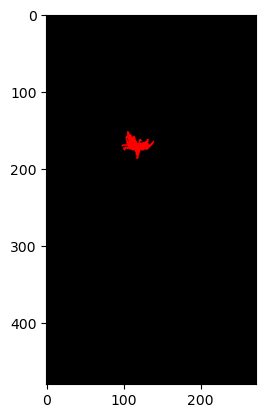

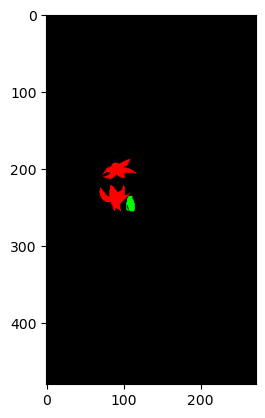

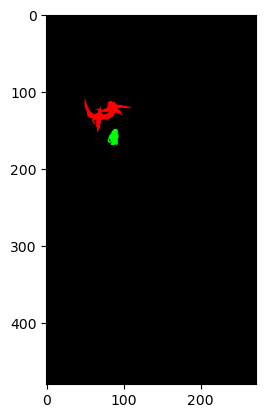

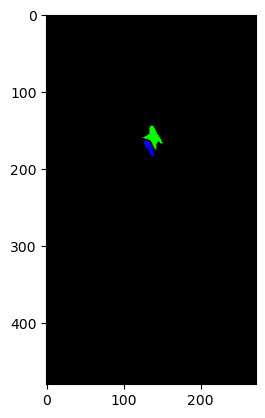

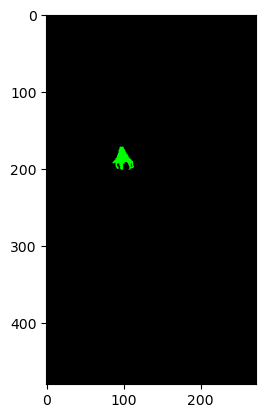

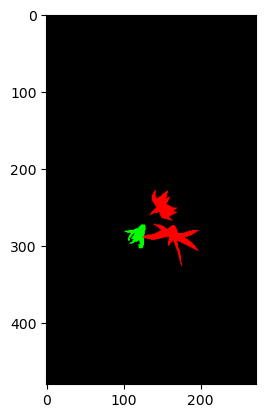

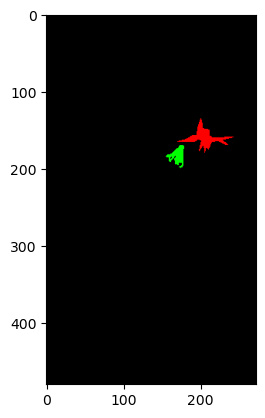

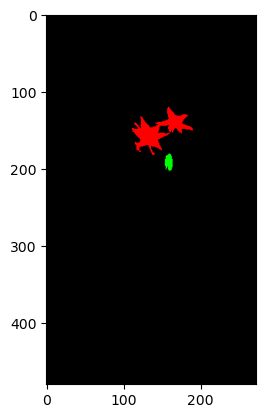

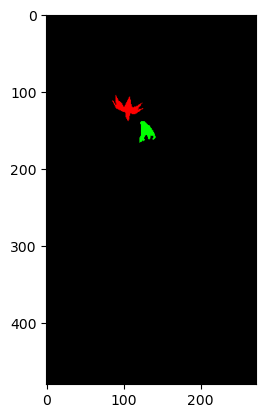

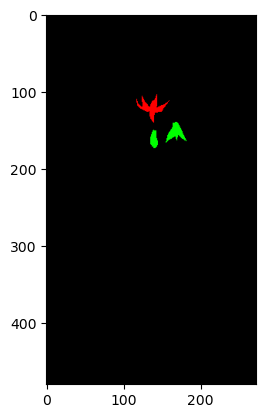

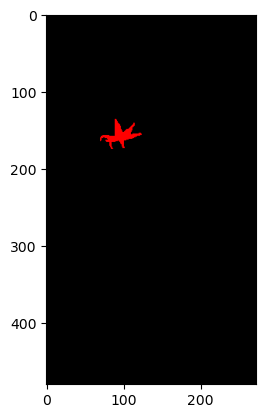

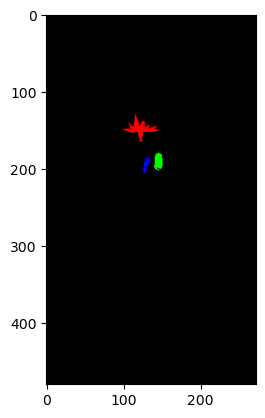

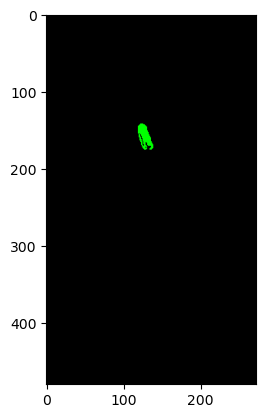

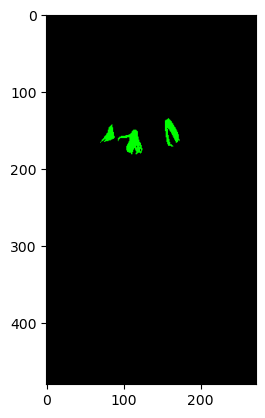

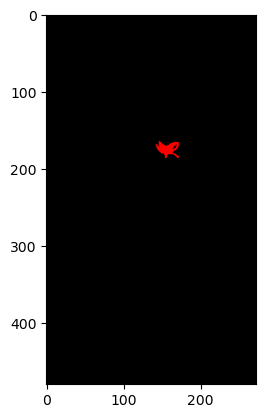

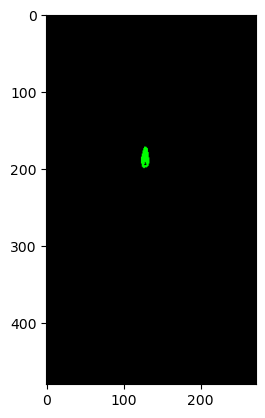

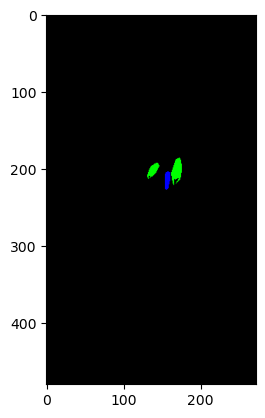

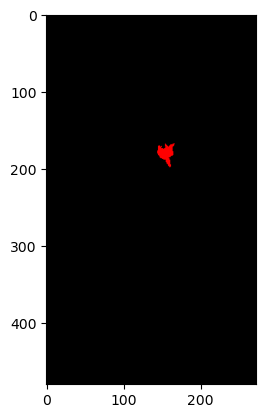

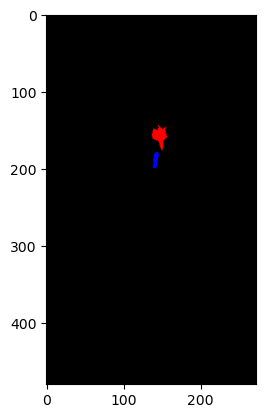

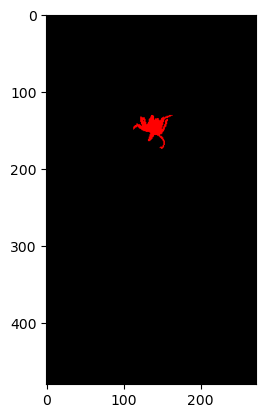

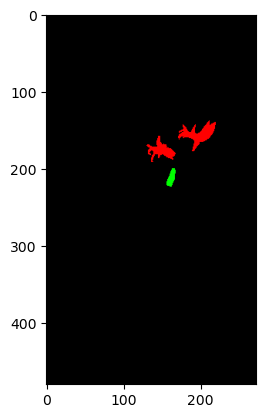

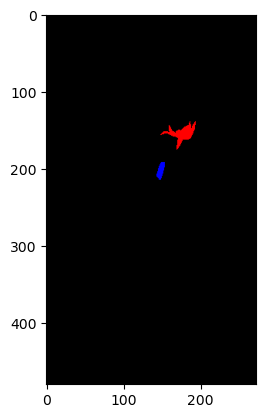

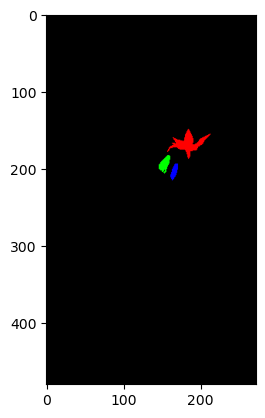

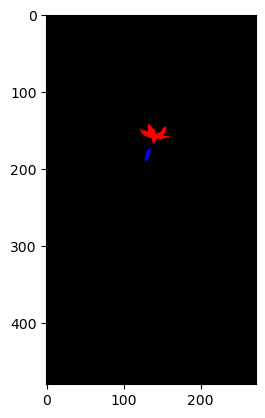

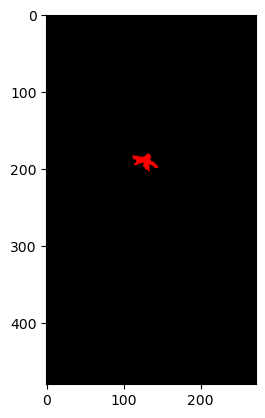

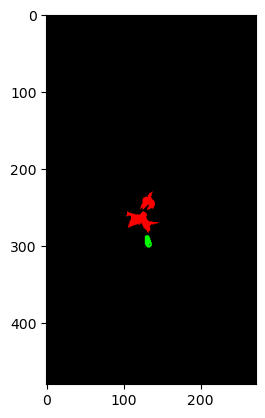

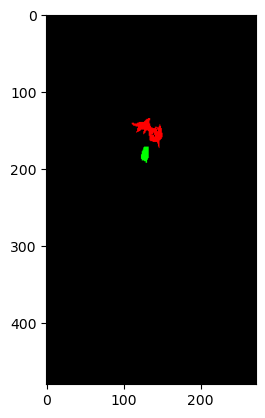

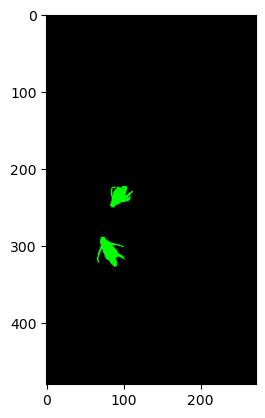

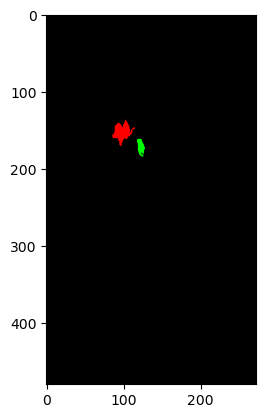

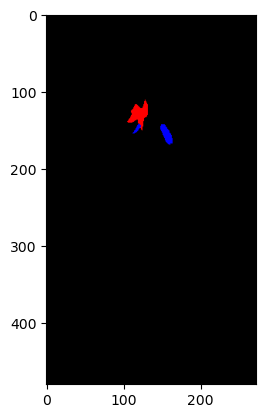

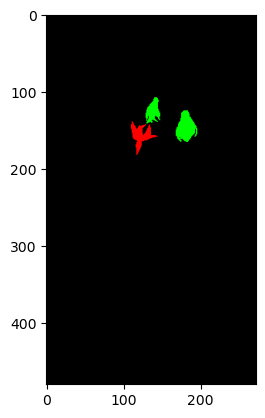

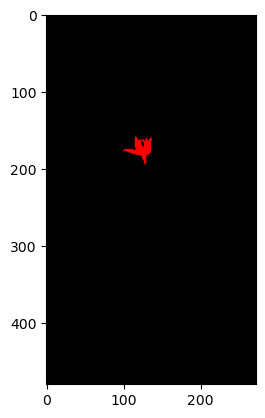

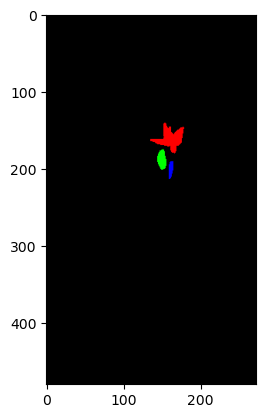

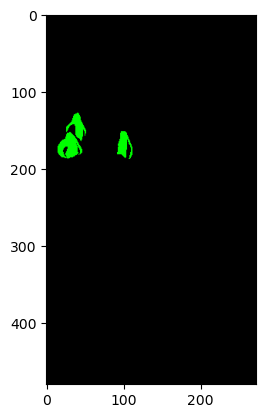

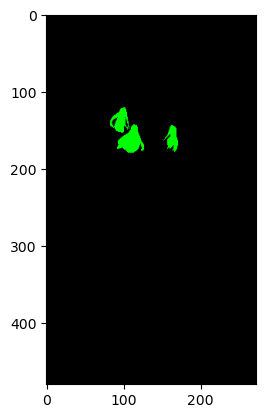

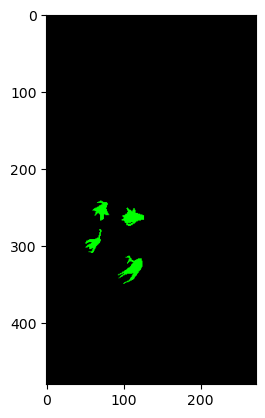

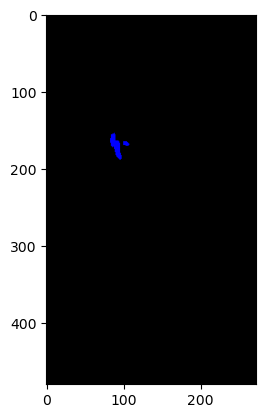

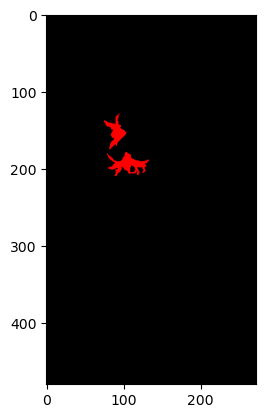

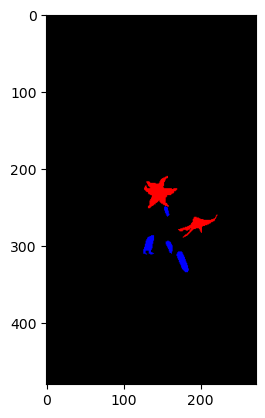

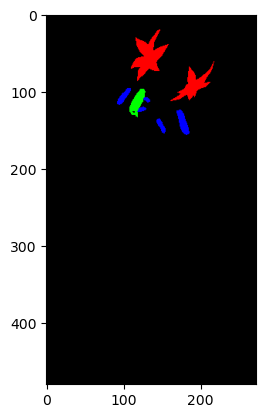

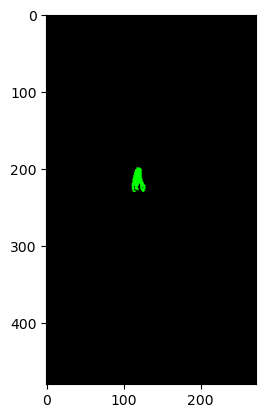

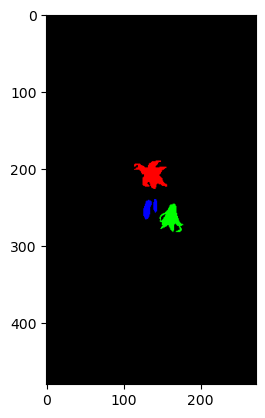

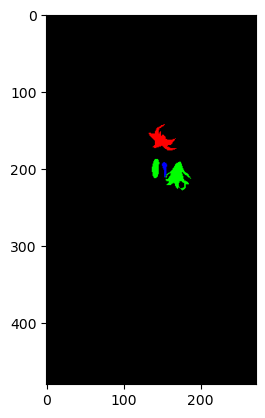

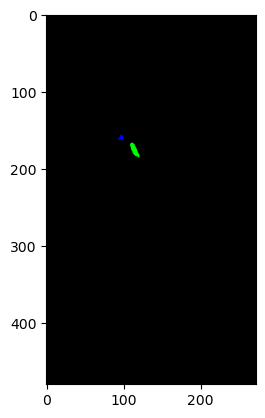

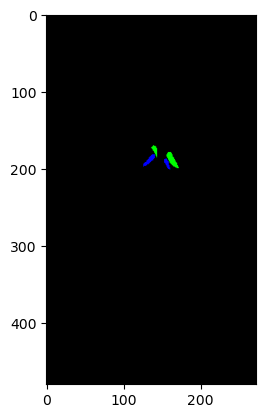

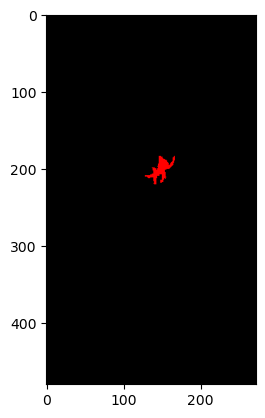

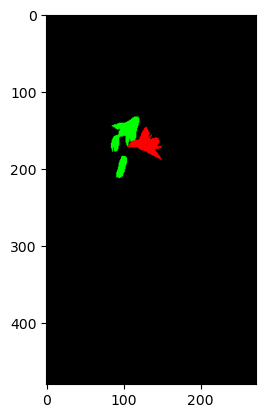

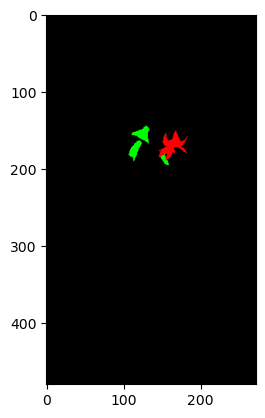

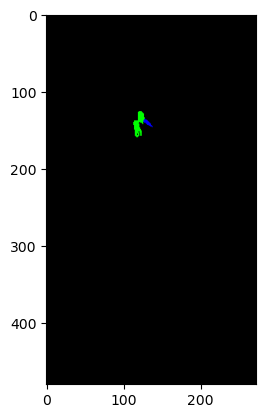

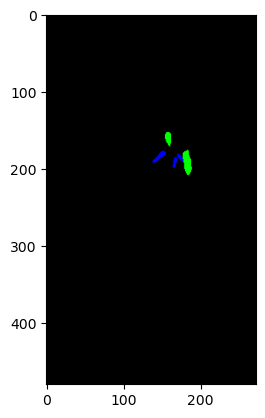

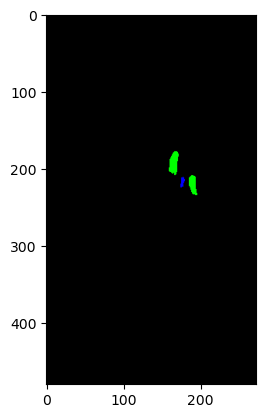

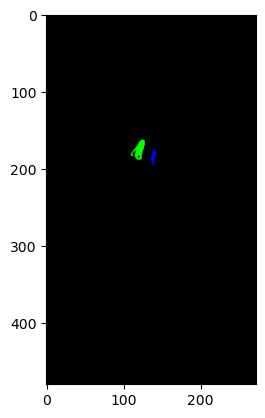

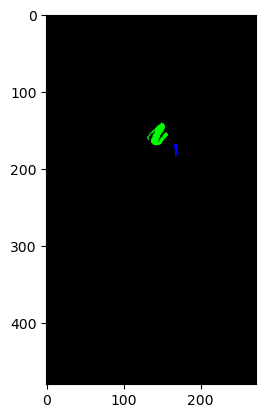

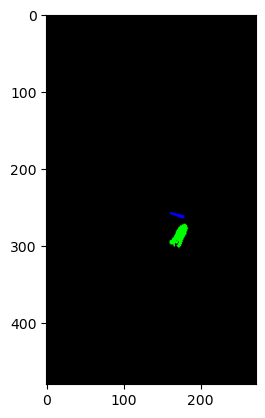

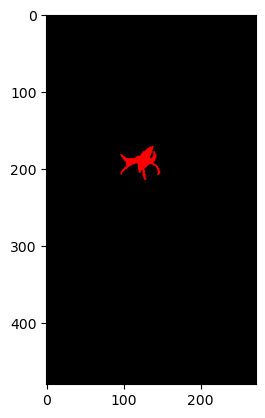

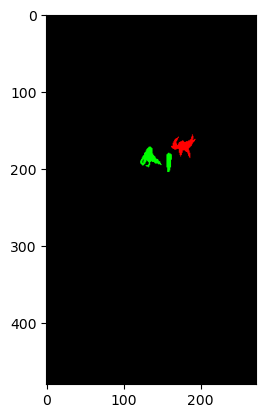

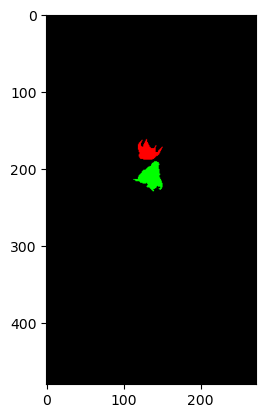

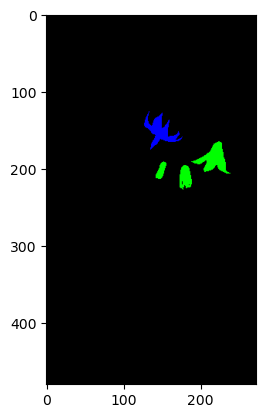

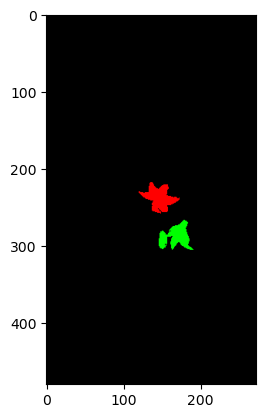

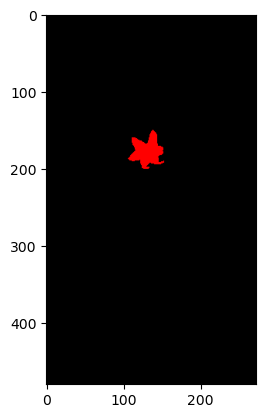

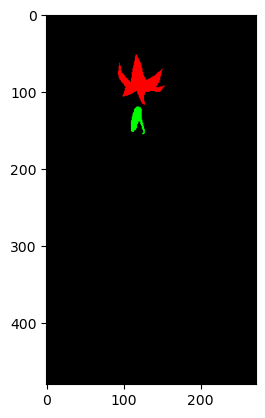

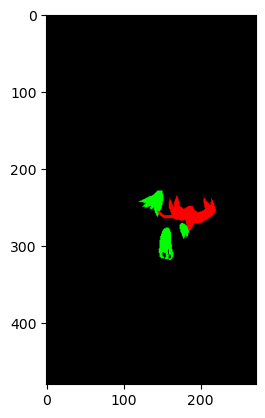

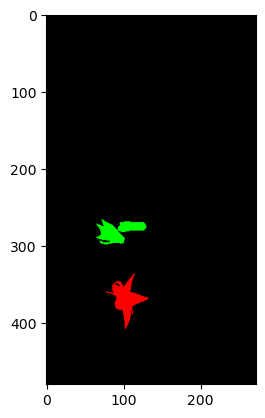

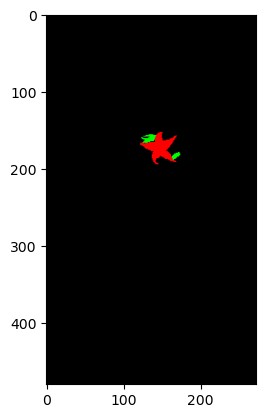

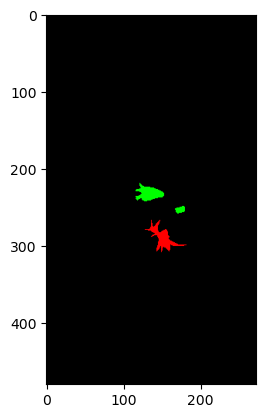

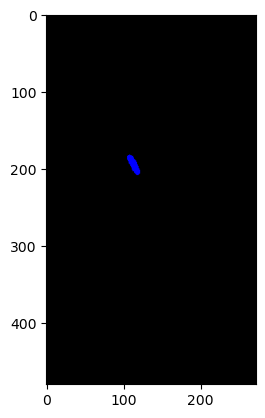

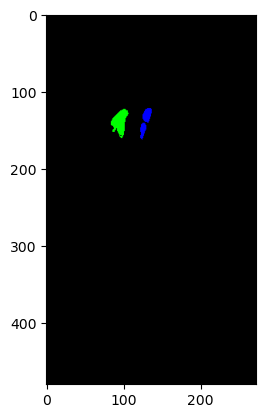

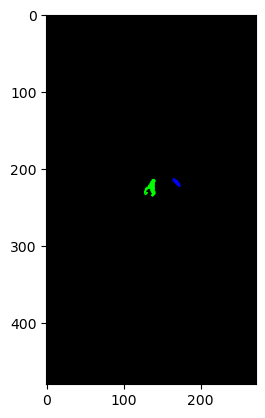

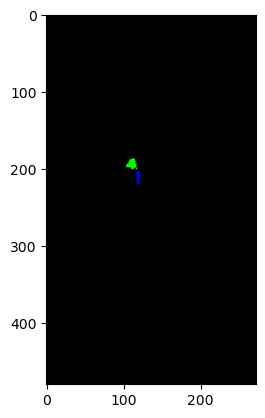

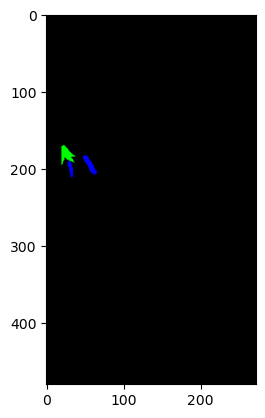

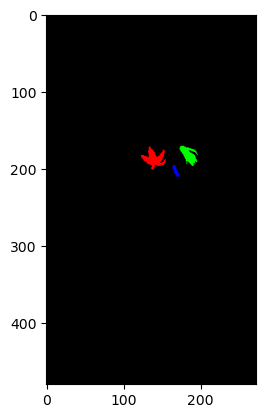

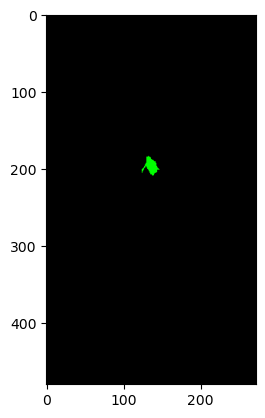

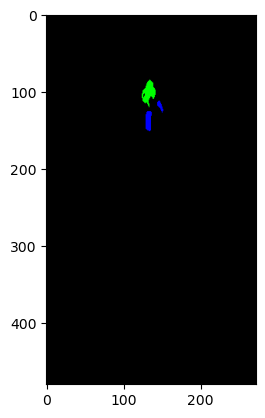

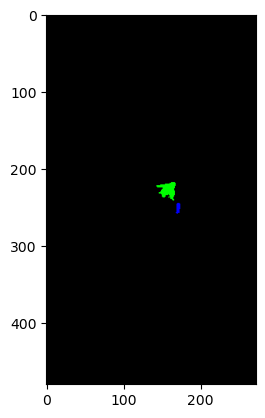

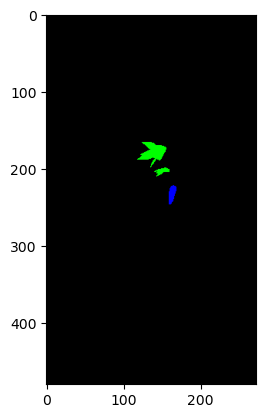

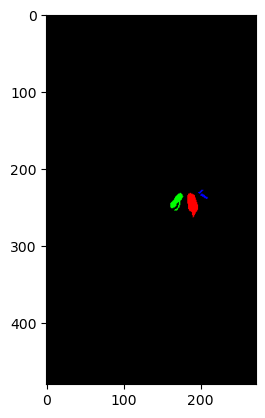

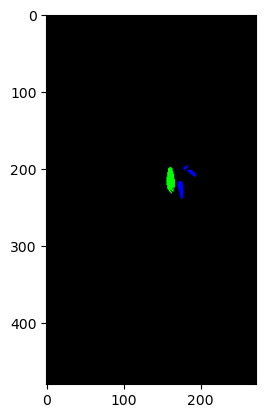

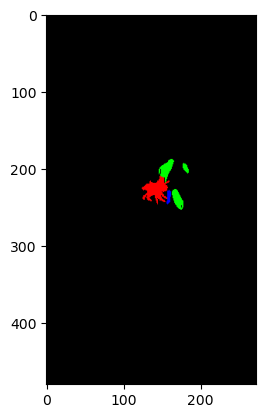

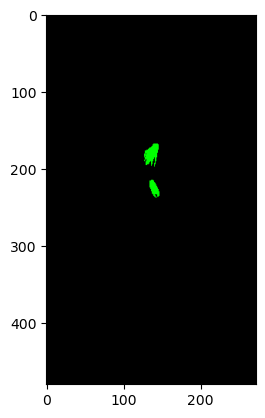

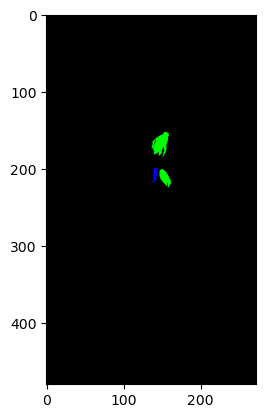

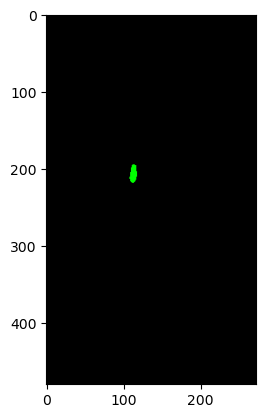

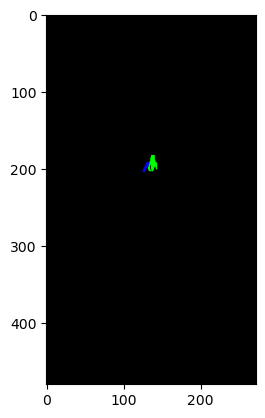

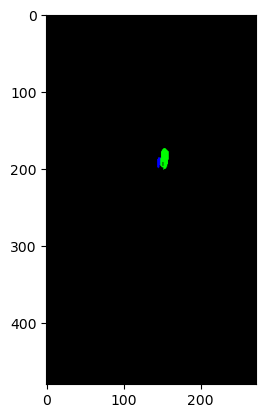

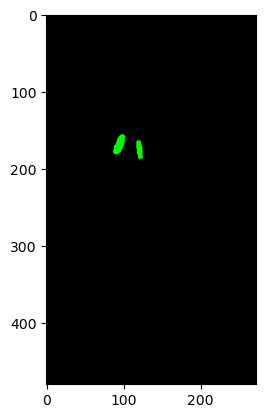

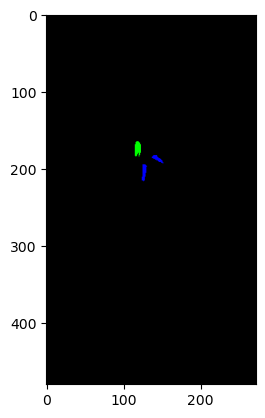

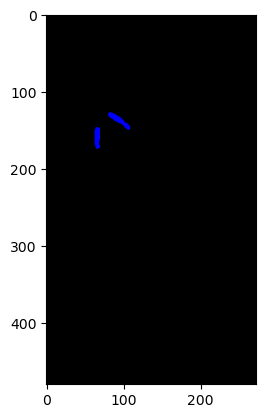

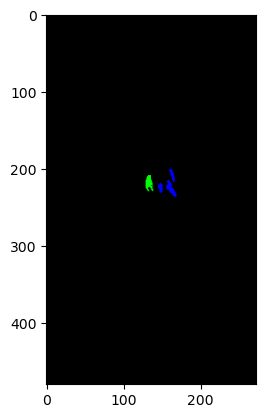

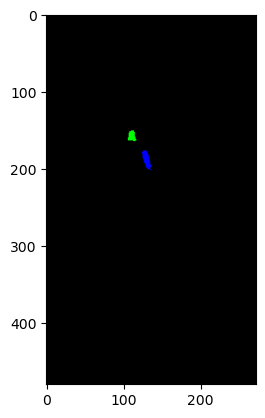

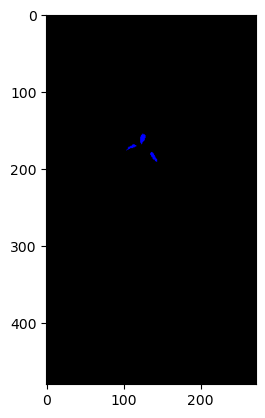

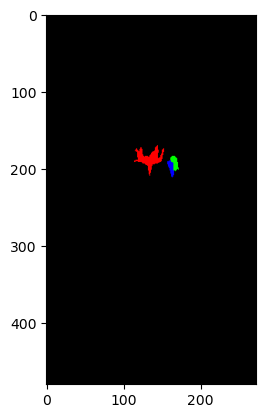

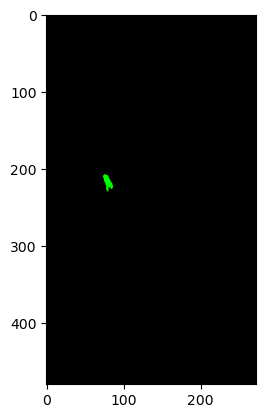

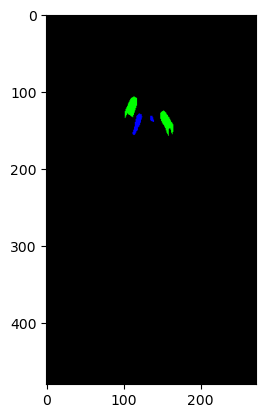

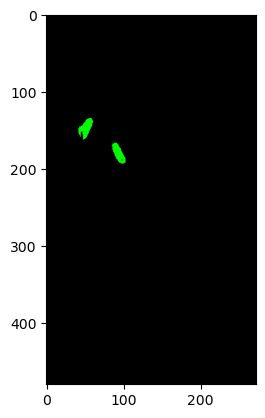

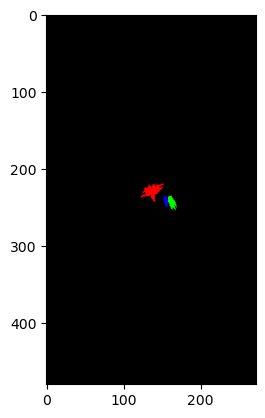

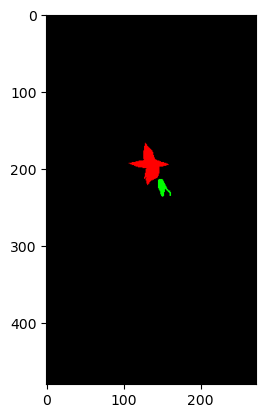

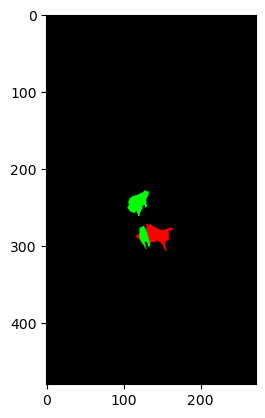

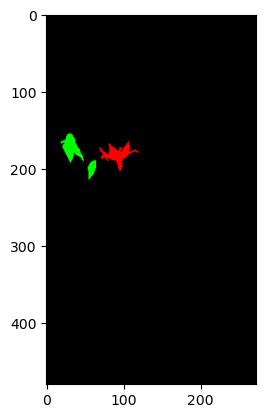

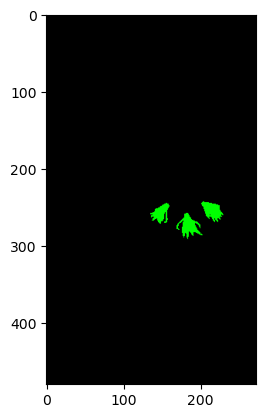

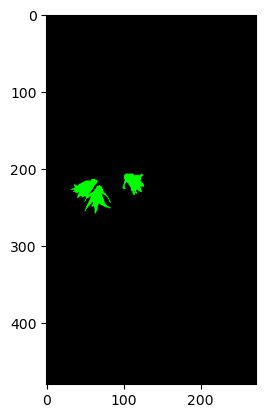

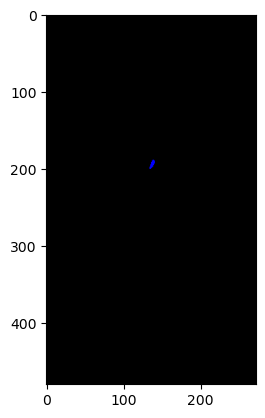

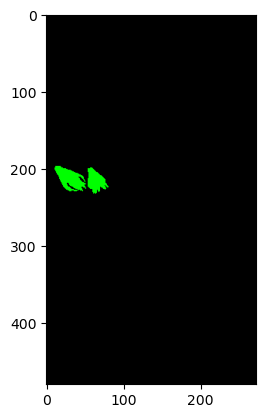

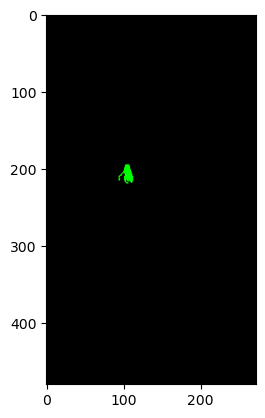

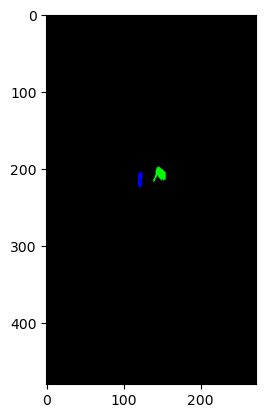

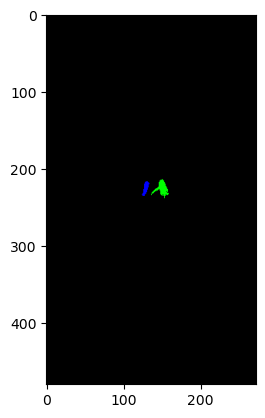

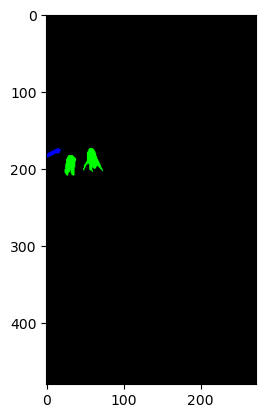

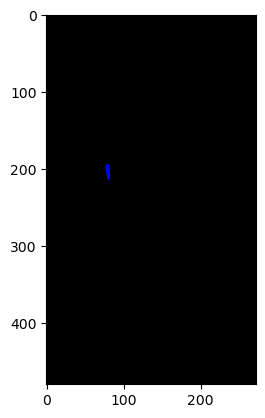

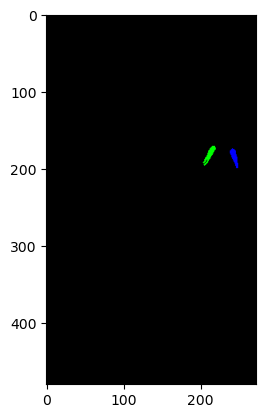

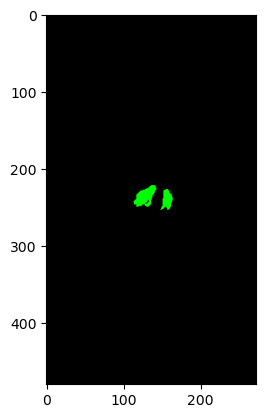

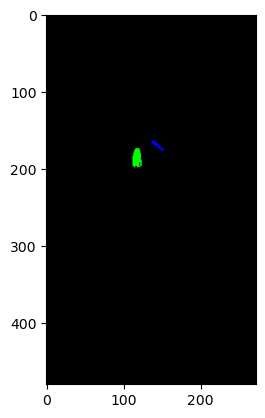

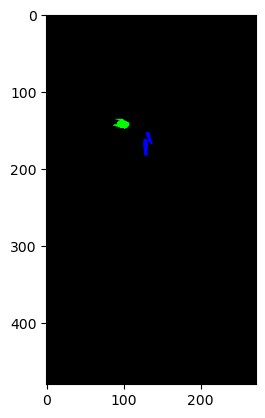

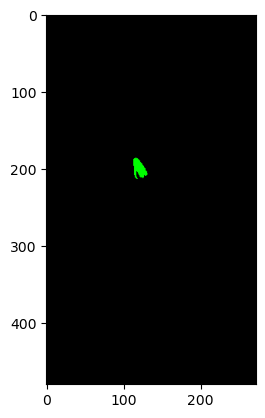

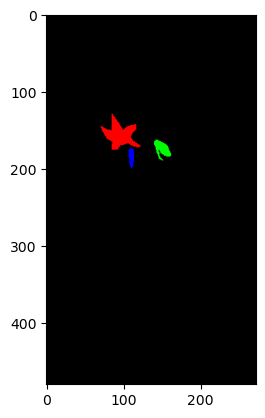

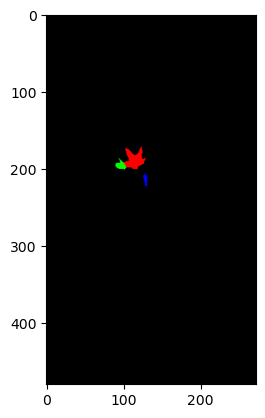

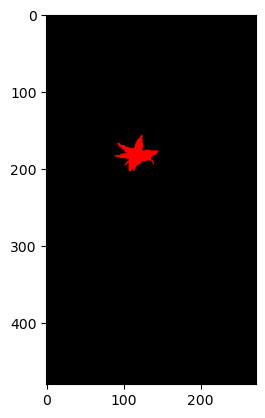

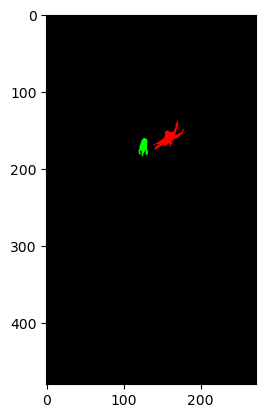

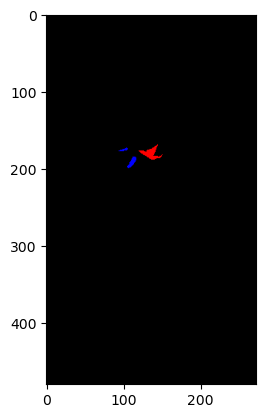

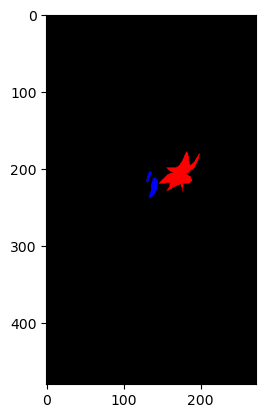

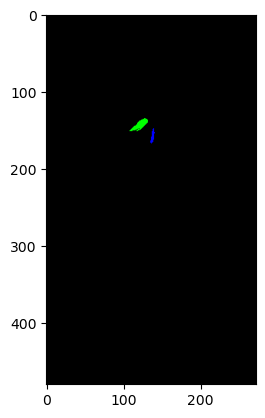

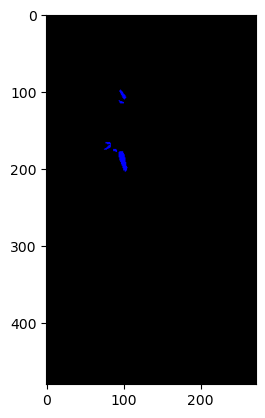

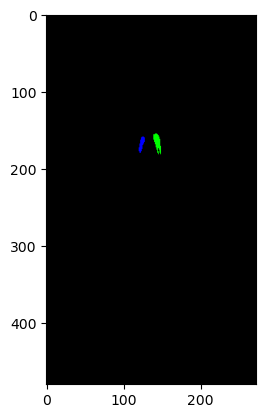

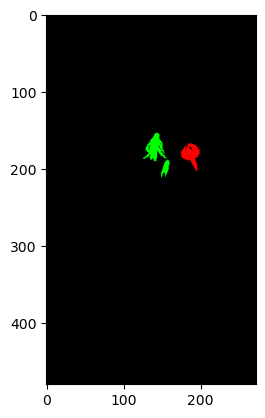

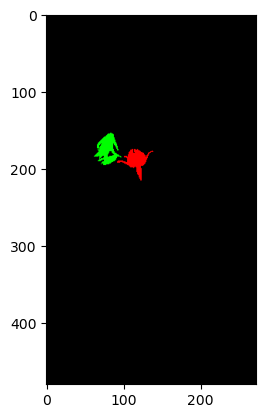

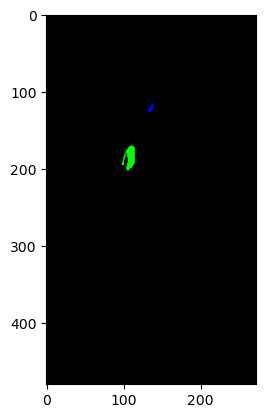

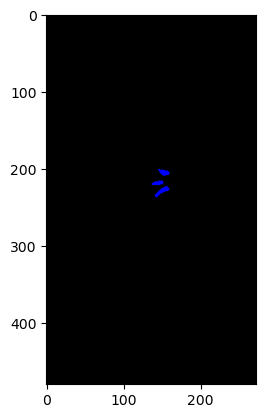

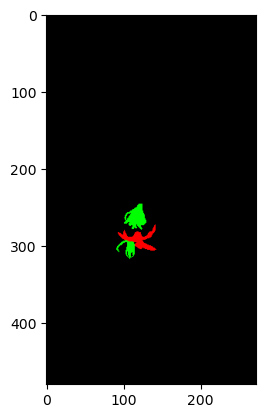

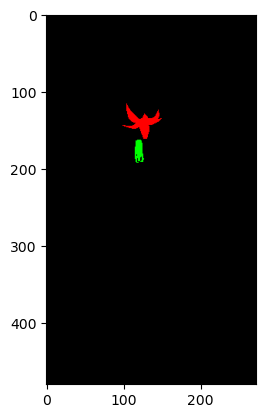

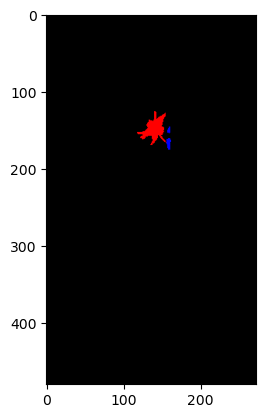

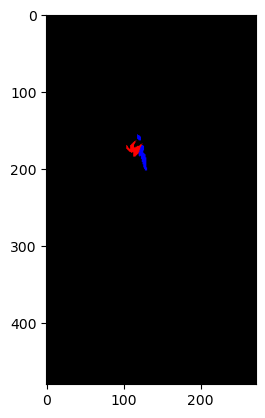

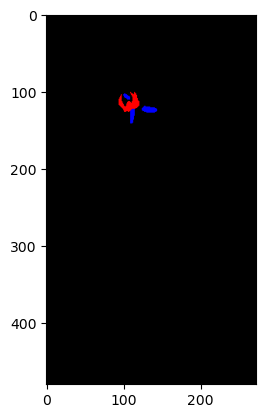

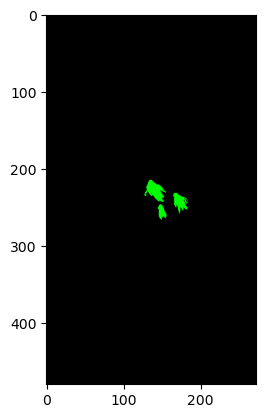

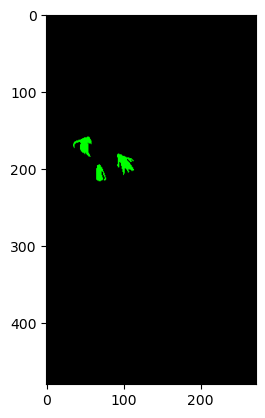

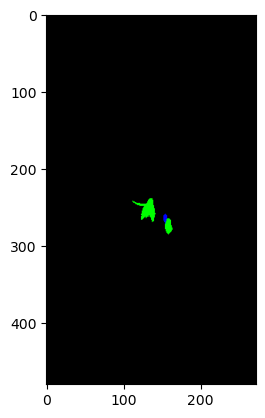

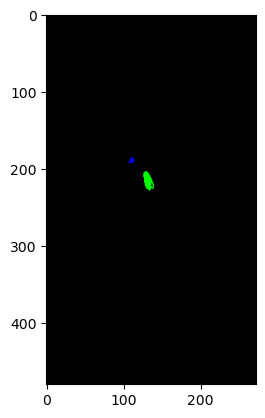

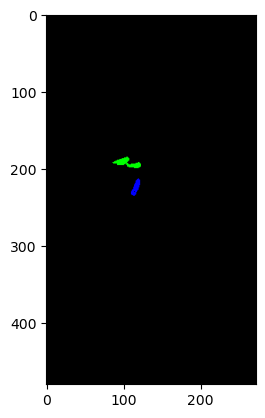

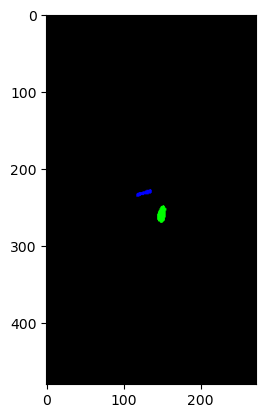

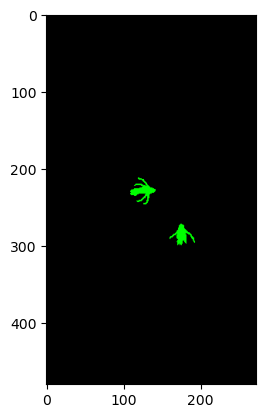

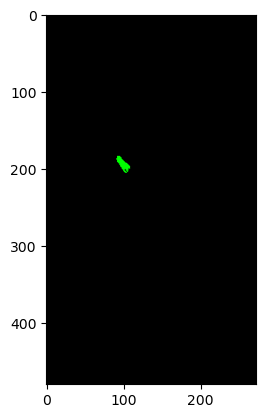

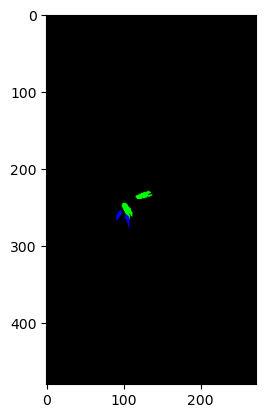

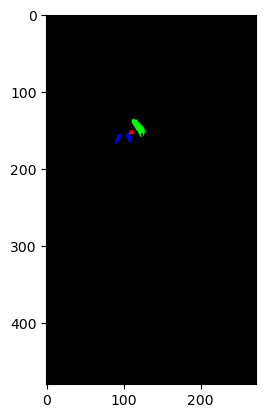

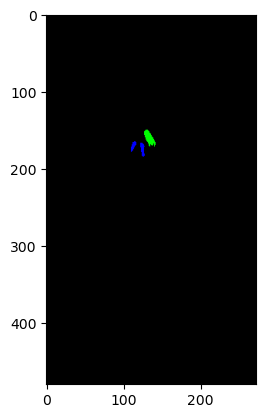

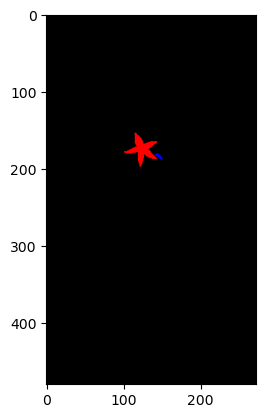

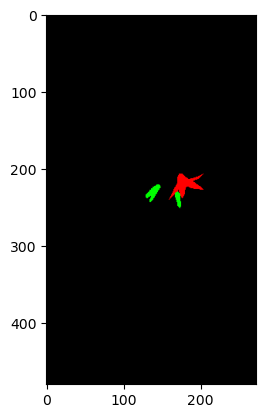

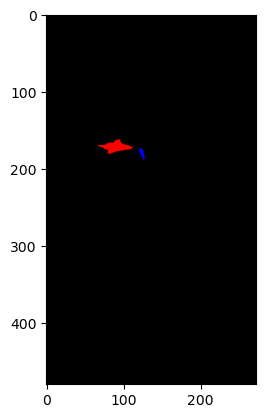

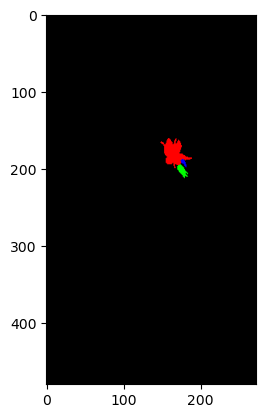

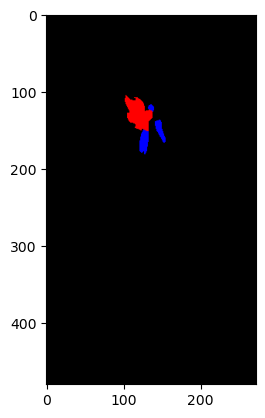

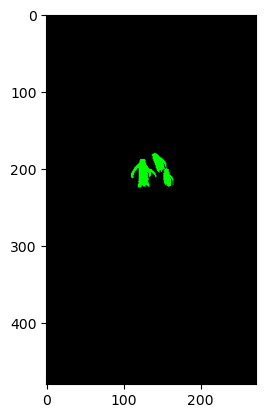

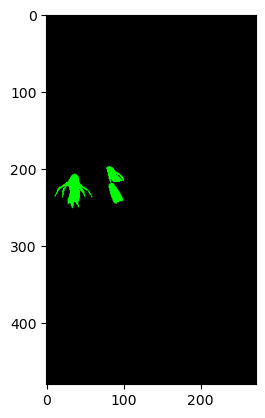

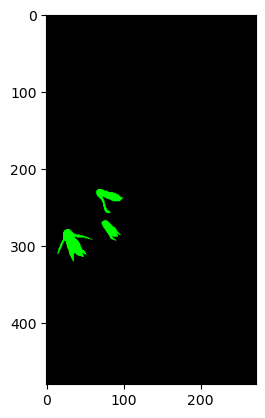

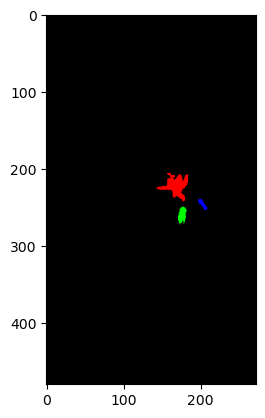

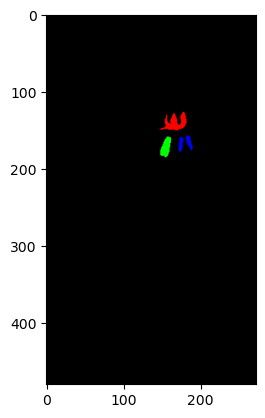

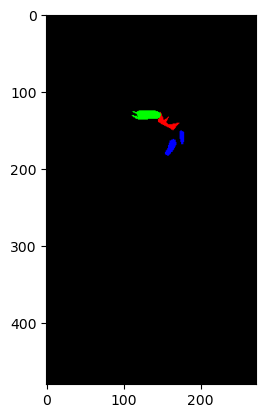

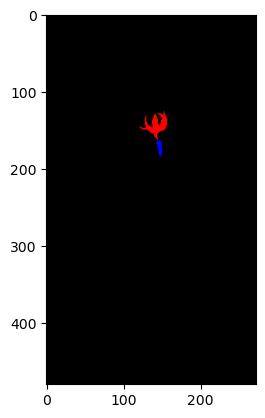

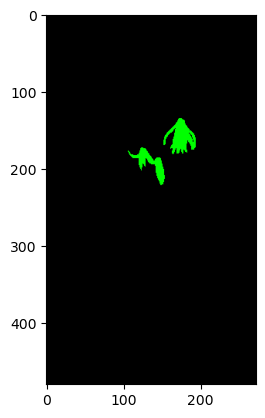

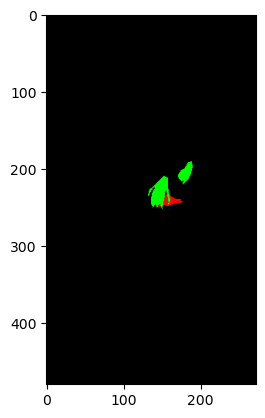

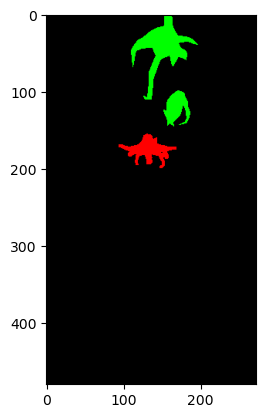

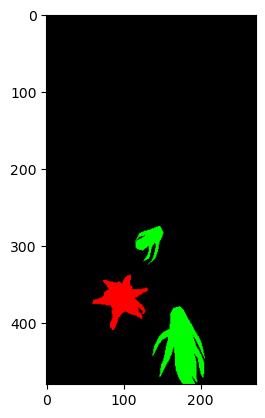

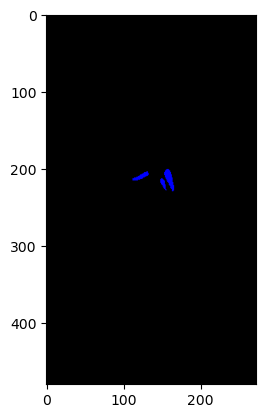

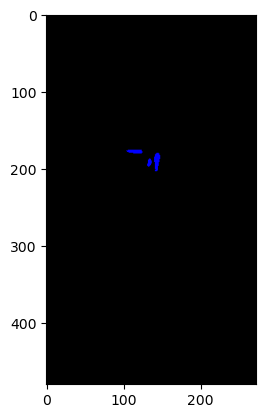

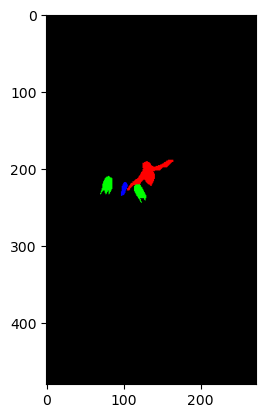

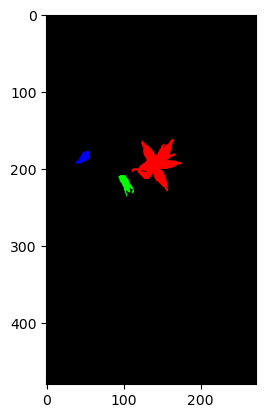

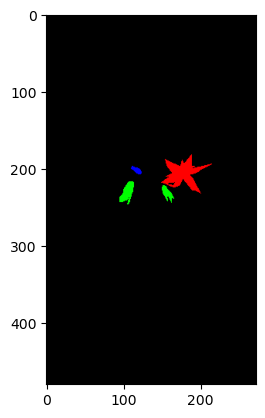

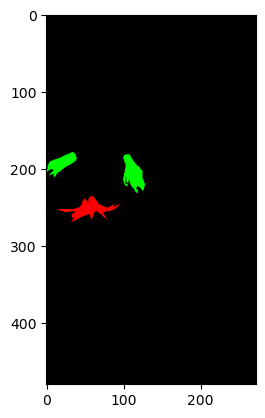

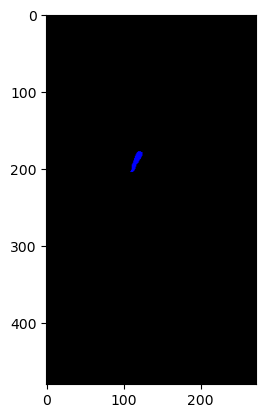

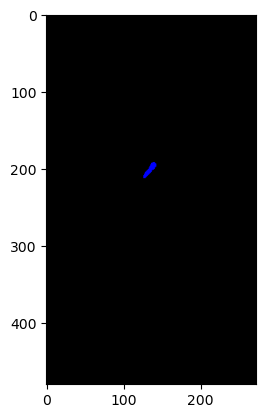

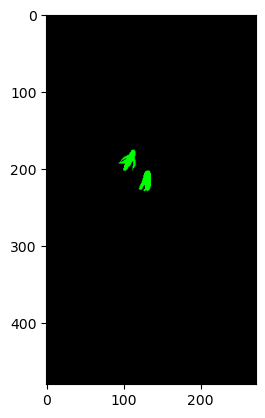

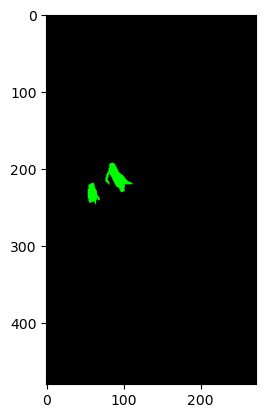

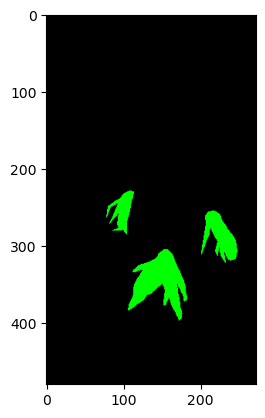

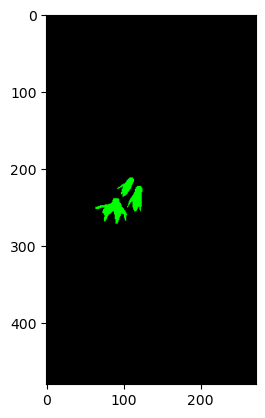

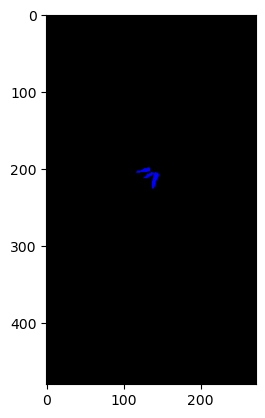

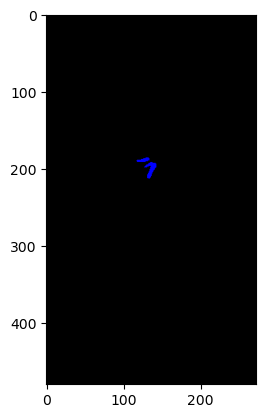

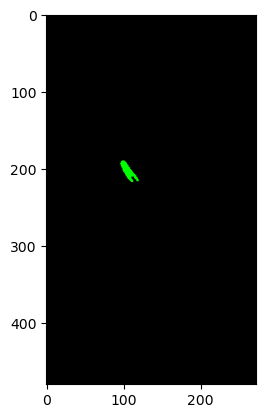

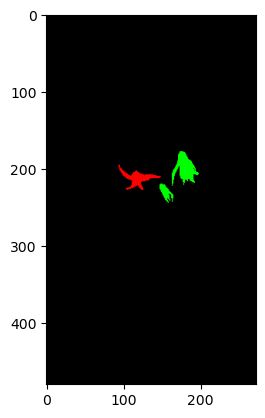

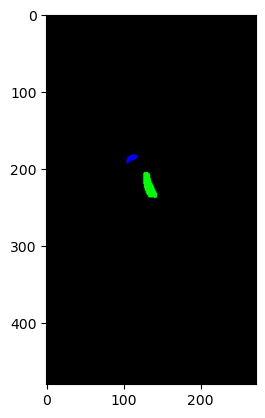

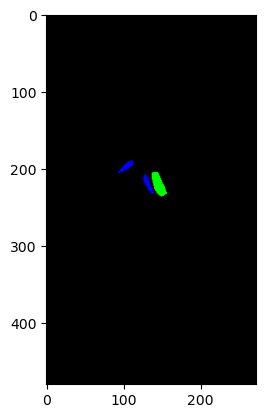

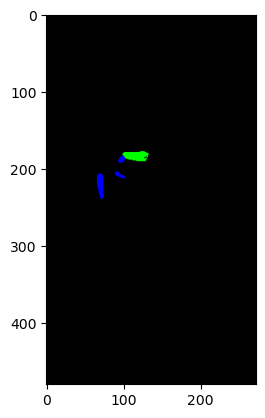

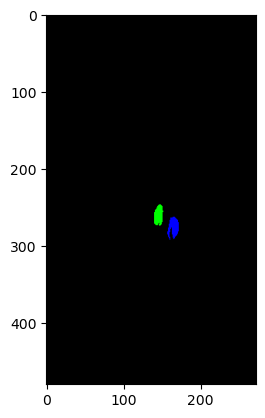

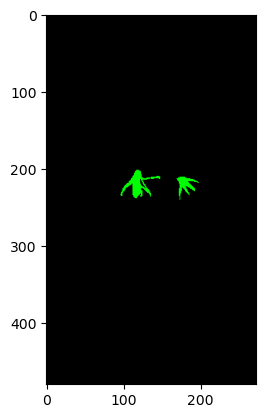

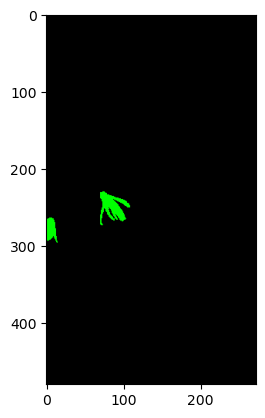

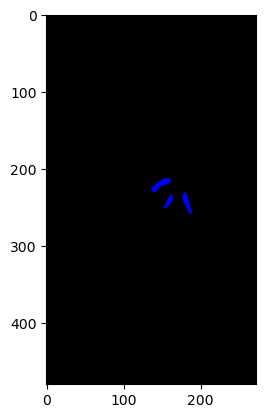

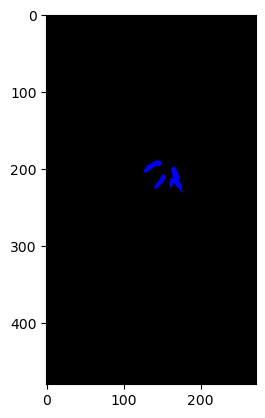

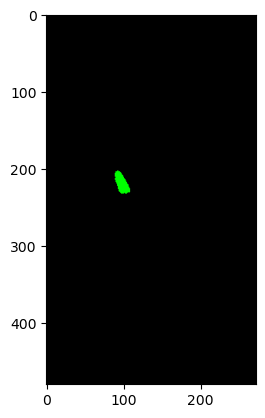

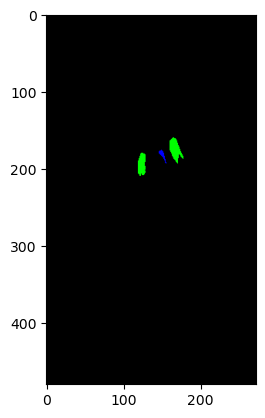

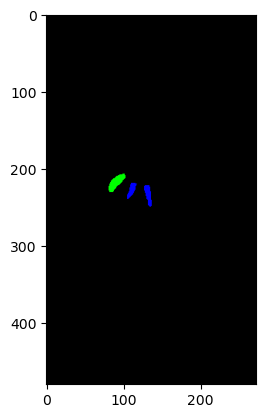

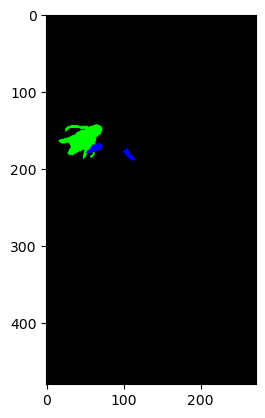

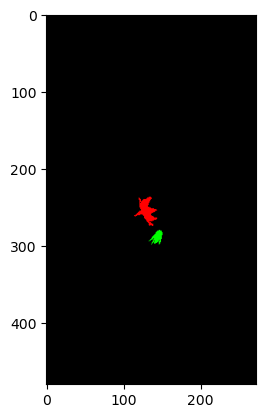

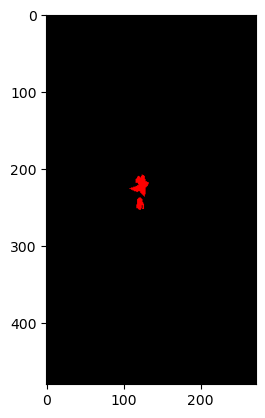

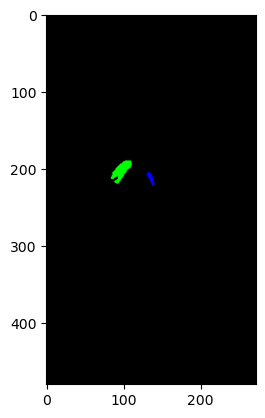

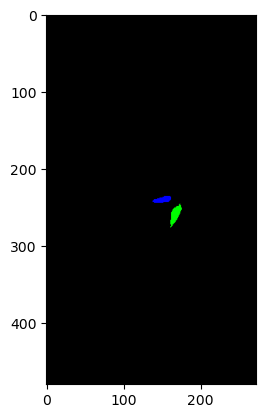

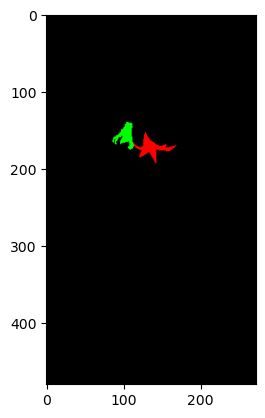

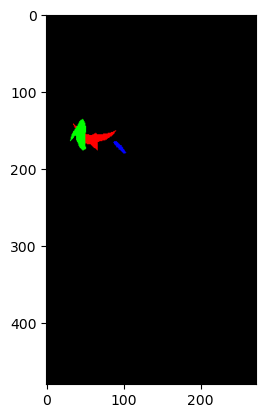

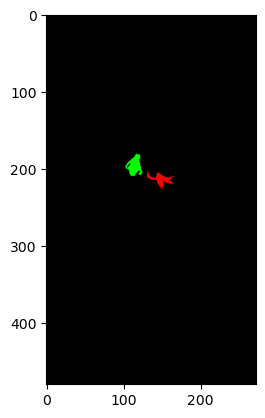

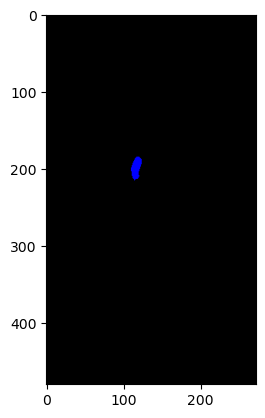

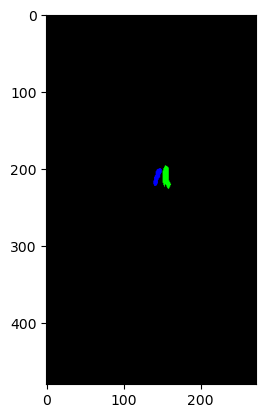

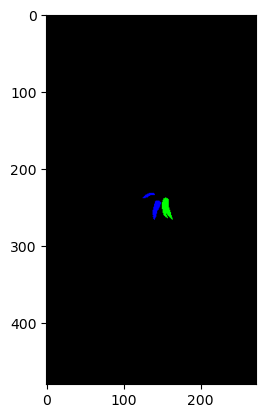

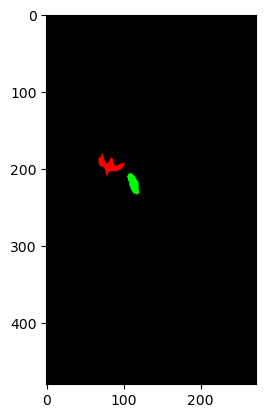

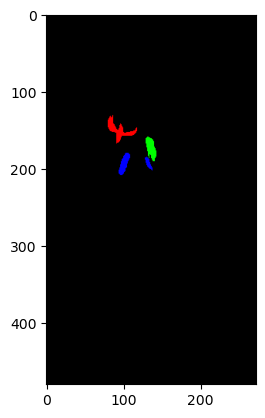

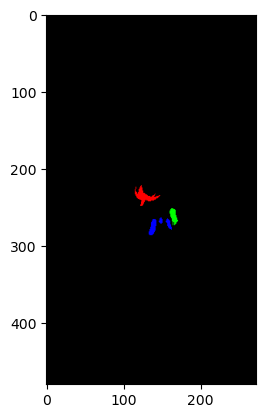

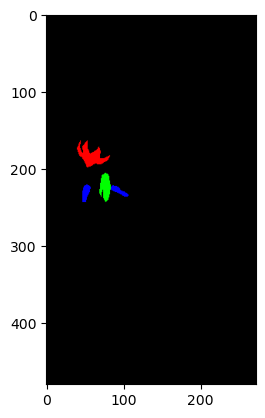

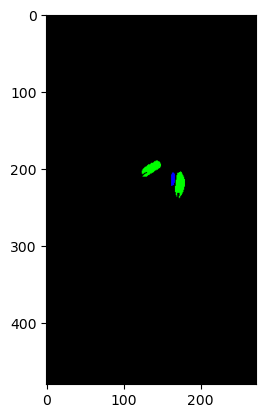

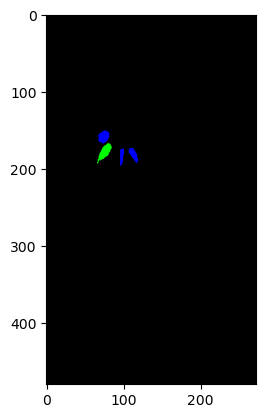

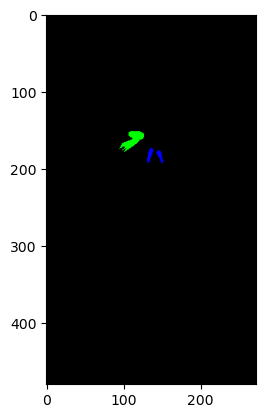

In [2]:
img_directory = 'E:\\Unet\\개화군(꽃)_축소이미지'
json_directory = 'E:\\Unet\\개화군(꽃)_축소JSON'

image_files = [os.path.join(img_directory, file) for file in os.listdir(img_directory) if file.endswith('.png')][:500]
json_files = [os.path.join(json_directory, file.replace('.png', '.json')) for file in os.listdir(img_directory) if file.endswith('.png')][:500]

print(f"Number of image files: {len(image_files)}")
print(f"Number of json files: {len(json_files)}")

for image_file, json_file in zip(image_files, json_files):
    image = Image.open(image_file)
    image = np.array(image)

    if image is None:
        print(f"Cannot load image: {image_file}")
        continue

    with open(json_file, 'r') as f:
        data = json.load(f)

    original_size = (data['imageWidth'], data['imageHeight'])

    # 라벨별 RGB 값 지정
    colors = [(0, 0, 0), (255, 0, 0), (0, 255, 0), (0, 0, 255)]

    # 세그멘테이션 이미지 초기화 (모든 픽셀 값이 0인 이미지)
    segmentation = np.zeros((original_size[1], original_size[0], 3), dtype=np.uint8)

    shapes = data['shapes']
    
    # points로 가져온 좌표 안쪽은 라벨에 따라 다른 색상으로 라벨링
    for shape in shapes:
        points = np.array(shape['points'], dtype=np.int32)
        label = shape['label']
        if label == "tom_flower_poly":
            cv2.fillPoly(segmentation, [points], colors[1])
        elif label == "tom_flower_half_poly":
            cv2.fillPoly(segmentation, [points], colors[2])
        elif label == "tom_pre_flowering_poly":
            cv2.fillPoly(segmentation, [points], colors[3])
    
    new_image_path = os.path.join("E:/Unet/개화군(꽃)/", os.path.split(image_file)[1].replace('.png', '_seg.png'))

    img_pil = Image.fromarray(segmentation)
    img_pil.save(new_image_path)

    # 세그멘테이션 이미지를 화면에 출력
    plt.imshow(segmentation)
    plt.show()

In [3]:
def load_data(image_files, segmentation_files, target_size):
    images = []
    labels = []

    for image_file, segmentation_file in zip(image_files, segmentation_files):
        # 이미지 로드
        image = load_img(image_file, target_size=target_size)
        image = img_to_array(image)

        # 세그멘테이션 이미지 로드
        segmentation = load_img(segmentation_file, target_size=target_size, color_mode="grayscale")
        segmentation = img_to_array(segmentation)
        segmentation = segmentation / 255.0  # 픽셀 값을 0과 1 사이로 정규화

        images.append(image)
        labels.append(segmentation)

    # numpy array로 변환
    images = np.array(images)
    labels = np.array(labels)

    return images, labels


In [11]:
def ConvBlock(filters, inputs):
    x = Conv2D(filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [4]:
def create_model(input_shape):
    inputs = Input(input_shape)

    conv1 = ConvBlock(64, inputs)
    drop1 = Dropout(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

    conv2 = ConvBlock(128, pool1)
    drop2 = Dropout(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

    conv3 = ConvBlock(256, pool2)
    drop3 = Dropout(0.2)(conv3)

    # Bridge
    bridge = ConvBlock(512, drop3)

    up4 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(bridge)
    merge4 = concatenate([drop2, up4], axis=3)
    conv4 = ConvBlock(128, merge4)
    drop4 = Dropout(0.2)(conv4)

    up5 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(drop4)
    merge5 = concatenate([drop1, up5], axis=3)
    conv5 = ConvBlock(64, merge5)
    drop5 = Dropout(0.2)(conv5)

    conv6 = Conv2D(4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop5)  # 유닛 수를 4개로 변경
    conv7 = Conv2D(4, 1, activation='softmax')(conv6)  # 활성화 함수를 softmax로 변경

    model = Model(inputs=inputs, outputs=conv7)

    return model

In [5]:
img_directory = 'E:\\Unet\\개화군(꽃)_축소이미지'
segmentation_directory = 'E:/Unet/개화군(꽃)'

image_files = [os.path.join(img_directory, file) for file in os.listdir(img_directory) if file.endswith('.png')]
segmentation_files = [os.path.join(segmentation_directory, file.replace('.png', '_seg.png')) for file in os.listdir(img_directory) if file.endswith('.png')]

# 학습 데이터와 테스트 데이터로 나누는 부분
image_train_files = image_files[:360]
segmentation_train_files = segmentation_files[:360]
image_test_files = image_files[360:400]
segmentation_test_files = segmentation_files[360:400]

# 이미지와 세그멘테이션 레이블의 크기를 조정할 크기
target_size = (480, 272)

def load_data(image_files, segmentation_files, target_size):
    images = []
    labels = []

    for image_file, segmentation_file in zip(image_files, segmentation_files):
        # 이미지 로드
        image = load_img(image_file, target_size=target_size)
        image = img_to_array(image)

        # 세그멘테이션 이미지 로드
        segmentation = load_img(segmentation_file, target_size=target_size, color_mode="grayscale")
        segmentation = img_to_array(segmentation)
        segmentation = segmentation / 85  # 픽셀 값을 0, 1, 2, 3으로 변경

        # "tom_flower_poly" 라벨에 해당하는 영역이 3개 이상인지 확인
        num_labels, _ = cv2.connectedComponents((segmentation == 1).astype(np.uint8))
        label = 1 if num_labels - 1 >= 3 else 0  # num_labels에는 배경에 해당하는 라벨도 포함되어 있으므로 1을 빼줍니다.

        images.append(image)
        labels.append(label)

    # numpy array로 변환
    images = np.array(images)
    labels = np.array(labels)

    return images, labels


# 학습 데이터 로드
x_train, y_train = load_data(image_train_files, segmentation_train_files, target_size)

# 학습 데이터를 평가하는 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 테스트 데이터 로드
x_test, y_test = load_data(image_test_files, segmentation_test_files, target_size)


In [9]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (288, 480, 272, 3)
y_train shape: (288,)


In [12]:
# 모델 생성
input_shape = (480, 272, 3)  # 실제 이미지의 크기
model = create_model(input_shape=input_shape)  # 실제 이미지 크기에 맞게 모델 생성

# 모델 컴파일
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])  # 손실 함수를 categorical_crossentropy로 변경

# 모델 학습
history = model.fit(x_train, y_train, batch_size=4, epochs=30, validation_data=(x_val, y_val))

# 모델 저장
model.save('unet_model_truss.h5')

Epoch 1/30


ValueError: in user code:

    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "D:\Anaconda\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "D:\Anaconda\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "D:\Anaconda\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "D:\Anaconda\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "D:\Anaconda\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "D:\Anaconda\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (4,) and (4, 480, 272, 4) are incompatible


In [ ]:
# 모델 평가
loss, acc = model.evaluate(x_test, y_test, batch_size=4)
print(f"Test Loss: {loss}, Test Accuracy: {acc}")

# 모델 예측
predictions = []
batch_size = 4  # 배치 크기를 조절하실 수 있습니다.
for i in range(0, len(x_test), batch_size):
    batch = x_test[i:i+batch_size]
    batch_predictions = model.predict(batch)
    predictions.extend(batch_predictions)

In [ ]:
# 예측 결과 시각화
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_test[18] / 255.0)        # 원본 이미지
ax[0].set_title("Input Image")
ax[1].imshow(predictions[18].squeeze(), cmap='gray')  # 예측된 세그멘테이션 결과
ax[1].set_title("Predicted Segmentation")
plt.show()

In [ ]:
# 결과를 확인하기 위해 작성한 코드
print(predictions[1])